# Introduction - Topic Choice and Context of Project
Corn is one of the most important and largest agricultural commodities in the world. In 2022 the global corn market produced 1,151.36 million metric tons and in the US alone the market size measured by revenue was $94.5bn (Shahbandeh, M. 2023, February 20) (IBISWorld, 2023). Most of us are familiar with sweet corn, the kind that we eat at our dinner tables, however, the market segmentation and use of corn is much broader in both scope and scale. If we look at the US market 47% of corn produced is used for livestock feed, 13% is exported, 10% is for human consumption, and 30% is used to produce Ethanol. 

The global corn market is a very intricate system that when viewed from a macro scale is unmanageably complex. You have farmers, traders, processors, end users, weather patterns, prices, international trade, and hundreds of different variables and market participants that influence the structure and behavior of the economics of this commodity. Our project aims to focus on a few of what we hypothesize are the most important variables that influence the corn market and leverage the data science workflow to extract new meaning from our datasets that we can use to provide insights in answering our guiding questions which will be discussed in the sections to follow. 

The source of our datasets have come from the United States Department of Agriculture National Agricultural Statistics Service. NASS has developed a database called Quick Stats that gives the public access to the agricultural data they publish. 

A link to the database tool is here: https://quickstats.nass.usda.gov/
A glossary of abbreviations and acronyms used in quick stats can be found here: https://quickstats.nass.usda.gov/src/glossary.pdf
Lastly, a link to their parameters definition documentation can be found here: https://quickstats.nass.usda.gov/param_define

In [26]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import math

# Guiding Question One
## How Does Weather in the Midwest Influence Corn Yield?
We will be exploring droughts and rain specifically at states in the Midwest since they produce over one-third of the world’s corn. Specifically Illinois, Indiana and Iowa, the three I’s. For this question, we will be looking at years 1995-2022. 2023 is still currently in the harvest season of corn production so we will be looking up until the last full season.

We will be looking at this in three sections of interest; planting, growing and harvesting seasons. Planting season is in April in the Midwest. High amounts of flooding or high rain events can negatively impact this process as the required nitrogen could wash away. This nitrogen is needed for amino acids, protein, and chlorophyll production. Growing season for corn is typically from May through August. Drought can cause a slower growing process and bushels to mature too quickly. A severe drought during the corn reproductive stage can cause crop failure Harvesting season is commonly from September through November in the Midwest. Like the planting season, severe rain makes it difficult to harvest. 

In order to measure levels of droughts and rain, we will be using Palmer Z Indices from *Palmer z corn Belt data.csv*. This quantifies short-term drought and rain on a monthly scale rather than the standard Palmer Drought Severity Indices (PDSI) which is long-term drought-inducing circulation patterns. This is also better than most drought severity index variables since it takes soil moisture into account. This measurement is a range that spans from -10 (dry) to +10 (wet). For wetness, 1.00-2.49 is considered moderate, 2.50-3.49 is severe and anything greater is extreme. For dryness, (-1.25)-(-1.99) is considered moderate, (-2.00)-(-2.74) is severe and anything lower is extreme (National Centers for Environmental Information, March 2014). 

## Data Cleaning
First, we cleaned the dataset. There are 110 “divisions” that contain states, regions, and nationwide data. We needed to filter out the three I’s as the population. Next, removing any index data outside of the range need to be converted to NaN. We are looking at the timeline from 1995-2022. Filtering the data to these specific years is the final step. 

In [27]:
#The Palmer Drought Severity Index data cleaning (PDSI -10 (dry) to +10 (wet)
#we are only taking the states Illinois, Indiana and Iowa (divisions 11, 12 and 13)
palmer_data = pd.read_csv('Palmer z corn Belt data.csv')
palmer_data = palmer_data[palmer_data['DIVISION'].isin([11, 12, 13])]
palmer_data['DIVISION'] = palmer_data['DIVISION'].map({11: 'Illinois', 12: 'Indiana', 13: 'Iowa'})

#changing any value outside the range to NaN
def filter_values(val):
    if val > 10 or val < -10:
        return np.nan
    return val

#applying the filter function to all columns except 'DIVISION' and 'YEAR'
cols_to_filter = palmer_data.columns.difference(['DIVISION', 'YEAR'])
palmer_data[cols_to_filter] = palmer_data[cols_to_filter].applymap(filter_values)

#filter data for years between 1995 and 2022
palmer_data_filtered = palmer_data[(palmer_data['YEAR'] >= 1995) & (palmer_data['YEAR'] <= 2022)]

#display the cleaned data
print(palmer_data_filtered.head())
print(palmer_data_filtered.tail())

      DIVISION  YEAR  JANUARY  FEBRUARY  MARCH  APRIL   MAY  JUNE  JULY  \
1390  Illinois  1995     1.85     -1.00  -1.15   1.19  5.58 -0.63 -0.93   
1391  Illinois  1996     0.27     -1.30  -0.72   2.06  4.10  0.32  1.44   
1392  Illinois  1997     0.98      3.21  -0.38  -1.10  0.63 -0.11 -1.56   
1393  Illinois  1998     0.94      0.66   2.00   1.39 -0.01  4.27  0.04   
1394  Illinois  1999     3.19      0.74  -1.56   1.85 -0.71  1.42 -1.05   

      AUGUST  SEPTEMBER  OCTOBER  NOVEMBER  DECEMBER  
1390   -0.05      -2.22    -0.23     -0.65     -1.62  
1391   -1.40      -0.15    -0.49      0.61     -0.50  
1392    1.82      -1.08    -1.16     -0.89     -1.09  
1393   -0.03      -1.68     1.34     -0.55     -0.92  
1394   -0.59      -1.27    -1.50     -4.20     -1.42  
     DIVISION  YEAR  JANUARY  FEBRUARY  MARCH  APRIL   MAY  JUNE  JULY  \
1671     Iowa  2018     0.10      1.37   0.68  -0.41 -0.14  3.04 -0.06   
1672     Iowa  2019     1.03      2.97   0.84   0.20  5.97 -0.78 -0.45 

## Heatmaps
Our first visualization is to look at these Palmer Z Indices in a heatmap to spot any anomalies. Separating the data by the three corn production seasons was the first step by using the *pivot.table()* method. Finally, for the planting season we simply took the value from April, however, for growing and harvesting seasons we took the average indices from May through August and September through November, respectively. With the *matplotlib.pyplot* library, we plotted this cleaned data as heatmaps by state.

<Figure size 1152x432 with 0 Axes>

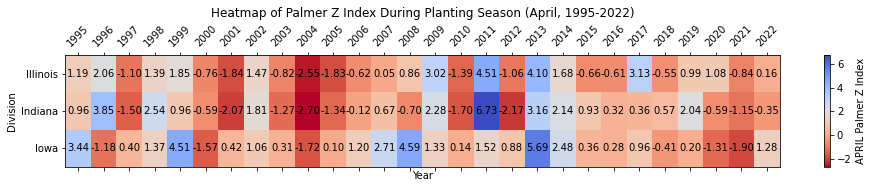

In [28]:
#Heatmap for April from 1995-2022 (planting season)
#filter data further by specifying the month of interest as April
#use pivot_table to restructure the data for the heatmap
palmer_data_planting_months = palmer_data_filtered[['DIVISION', 'YEAR', 'APRIL']]
heatmap_data_planting = palmer_data_planting_months.pivot_table(index="DIVISION", columns="YEAR", values="APRIL", aggfunc='mean')

#plotting the heatmap
#cmap is the colour and aspect allows cells to adjust to size
plt.figure(figsize=(16, 6))
heatmap_planting = plt.matshow(heatmap_data_planting, cmap="coolwarm_r", aspect='auto')

#colour bar, labels and title on graph
plt.colorbar(heatmap_planting, label='APRIL Palmer Z Index')
plt.xlabel('Year')
plt.ylabel('Division')
plt.title('Heatmap of Palmer Z Index During Planting Season (April, 1995-2022)')

#displays the years and states on the axes
plt.xticks(np.arange(len(heatmap_data_planting.columns)), heatmap_data_planting.columns, rotation=45)
plt.yticks(np.arange(len(heatmap_data_planting.index)), heatmap_data_planting.index)

#loops through each cell on heatmap and annotates with the index value
for i in range(len(heatmap_data_planting.index)):
    for j in range(len(heatmap_data_planting.columns)):
        plt.text(j, i, f"{heatmap_data_planting.iloc[i, j]:.2f}", ha='center', va='center')

#show the heatmap
plt.show()

/var/folders/rp/byq2p2690nlg8_ph65ct_z480000gn/T/ipykernel_42032/251894293.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  palmer_data_growing_months['AVG_MAY_AUG'] = palmer_data_growing_months[['MAY', 'JUNE', 'JULY', 'AUGUST']].mean(axis=1)


<Figure size 1152x432 with 0 Axes>

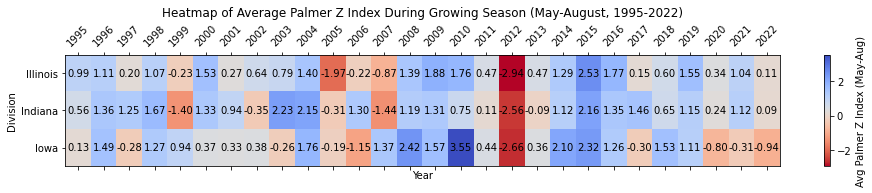

In [29]:
#Heatmap for May through August from 1995-2022 (growing season)
#filtering data further to use May through August 
#take the average Palmer Z Index for the months May through August
#use pivot_table to restructure the data for the heatmap
palmer_data_growing_months = palmer_data_filtered[['DIVISION', 'YEAR', 'MAY', 'JUNE', 'JULY', 'AUGUST']]
palmer_data_growing_months['AVG_MAY_AUG'] = palmer_data_growing_months[['MAY', 'JUNE', 'JULY', 'AUGUST']].mean(axis=1)
heatmap_data_growing = palmer_data_growing_months.pivot_table(index="DIVISION", columns="YEAR", values="AVG_MAY_AUG", aggfunc='mean')

#plotting the heatmap
#cmap is the colour and aspect allows cells to adjust to size
plt.figure(figsize=(16, 6))
heatmap_growing = plt.matshow(heatmap_data_growing, cmap="coolwarm_r", aspect='auto')

#colour bar, labels and title on graph
plt.colorbar(heatmap_growing, label='Avg Palmer Z Index (May-Aug)')
plt.xlabel('Year')
plt.ylabel('Division')
plt.title('Heatmap of Average Palmer Z Index During Growing Season (May-August, 1995-2022)')

#displays the years and states on the axes
plt.xticks(np.arange(len(heatmap_data_growing.columns)), heatmap_data_growing.columns, rotation=45)
plt.yticks(np.arange(len(heatmap_data_growing.index)), heatmap_data_growing.index)

#loops through each cell on heatmap and annotates with the average index value
for i in range(len(heatmap_data_growing.index)):
    for j in range(len(heatmap_data_growing.columns)):
        plt.text(j, i, f"{heatmap_data_growing.iloc[i, j]:.2f}", ha='center', va='center')

#show the heatmap
plt.show()

/var/folders/rp/byq2p2690nlg8_ph65ct_z480000gn/T/ipykernel_42032/632737025.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  palmer_data_harvest_months['AVG_SEP_NOV'] = palmer_data_harvest_months[['SEPTEMBER', 'OCTOBER', 'NOVEMBER']].mean(axis=1)


<Figure size 1152x432 with 0 Axes>

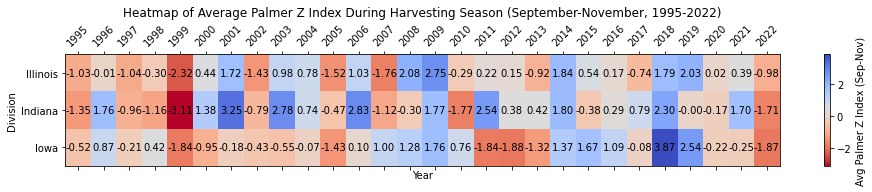

In [30]:
#Heatmap for September through November from 1995-2022 (harvest season)
#filter data further to use September through November 
#take the average Palmer Z Index for the months September through November
#use pivot_table to restructure the data for the heatmap
palmer_data_harvest_months = palmer_data_filtered[['DIVISION', 'YEAR', 'SEPTEMBER', 'OCTOBER', 'NOVEMBER']]
palmer_data_harvest_months['AVG_SEP_NOV'] = palmer_data_harvest_months[['SEPTEMBER', 'OCTOBER', 'NOVEMBER']].mean(axis=1)
heatmap_data_harvest = palmer_data_harvest_months.pivot_table(index="DIVISION", columns="YEAR", values="AVG_SEP_NOV", aggfunc='mean')

#plotting the heatmap
#cmap is the colour and aspect allows cells to adjust to size
plt.figure(figsize=(16, 6))
heatmap_harvest = plt.matshow(heatmap_data_harvest, cmap="coolwarm_r", aspect='auto')

#colour bar, labels and title on graph
plt.colorbar(heatmap_harvest, label='Avg Palmer Z Index (Sep-Nov)')
plt.xlabel('Year')
plt.ylabel('Division')
plt.title('Heatmap of Average Palmer Z Index During Harvesting Season (September-November, 1995-2022)')

#displays the years and states on the axes
plt.xticks(np.arange(len(heatmap_data_harvest.columns)), heatmap_data_harvest.columns, rotation=45)
plt.yticks(np.arange(len(heatmap_data_harvest.index)), heatmap_data_harvest.index)

#loops through each cell on heatmap and annotates with the average index value
for i in range(len(heatmap_data_harvest.index)):
    for j in range(len(heatmap_data_harvest.columns)):
        plt.text(j, i, f"{heatmap_data_harvest.iloc[i, j]:.2f}", ha='center', va='center')

#show the heatmap
plt.show()

## Heatmap Observations
When we look at these visuals, some key areas catch our eye. During the 2011 planting season, there was extreme wetness in Illinois and Indiana. Also, during the 2012 growing season there was a severe drought in Indiana and Iowa and it was even extreme in Illinois. We will further investigate these abnormalities further and compare this data to yield. 

## Cleaning and Merging the Yield Dataset
In order to look at corn yield over the years, we use the *Yield - 3Is.csv* from the USDA database and use the *Value* column. This is measured in bushels per acre, the amount of harvested production per unit of land for the year.

To clean this dataset, we are going to continue to look at the timeline from 1995-2022 to be able to use it along with the weather data so filtering these years is the first step. This included eliminating many rows that contained monthly forecasted values that we will not be using. Location wise, the file only contains the three I’s already, however, we just needed to rename the states to match the first dataset since they were all capitalized. Finally, we can merge this cleaned dataset with the previously cleaned Palmer Z Index data using the pandas library. 

In [31]:
#Importing and cleaning the corn yield dataset
#filter to only include rows that say "YEAR" in the 'Period' column and between the years 1995 and 2022
#rename the State and Year columns to match the palmer_data DataFrame for easier merging
#use map() to match the state names in palmer_data 
#keeping the 3 columns we need
corn_yield_data = pd.read_csv('Yield - 3Is.csv')
corn_yield_filtered = corn_yield_data[(corn_yield_data['Period'] == 'YEAR') & (corn_yield_data['Year'] >= 1995) & (corn_yield_data['Year'] <= 2022)]
corn_yield_filtered = corn_yield_filtered.rename(columns={'State': 'DIVISION', 'Year': 'YEAR'})
corn_yield_filtered['DIVISION'] = corn_yield_filtered['DIVISION'].map({'ILLINOIS': 'Illinois', 'INDIANA': 'Indiana', 'IOWA': 'Iowa'})
corn_yield_filtered = corn_yield_filtered[['DIVISION', 'YEAR', 'Value']]

#merge the corn yield data with the Palmer Z data based on the 'YEAR' and 'DIVISION'
merged_data = pd.merge(palmer_data_filtered, corn_yield_filtered, on=['YEAR', 'DIVISION'])

#displaying this merged data (new value column at the end)
merged_data.head()

,DIVISION,YEAR,JANUARY,FEBRUARY,MARCH,APRIL,MAY,JUNE,JULY,AUGUST,SEPTEMBER,OCTOBER,NOVEMBER,DECEMBER,Value
0,Illinois,1995,1.85,-1.00,-1.15,1.19,5.58,-0.63,-0.93,-0.05,-2.22,-0.23,-0.65,-1.62,113.0
1,Illinois,1996,0.27,-1.30,-0.72,2.06,4.10,0.32,1.44,-1.40,-0.15,-0.49,0.61,-0.50,136.0
2,Illinois,1997,0.98,3.21,-0.38,-1.10,0.63,-0.11,-1.56,1.82,-1.08,-1.16,-0.89,-1.09,129.0
3,Illinois,1998,0.94,0.66,2.00,1.39,-0.01,4.27,0.04,-0.03,-1.68,1.34,-0.55,-0.92,141.0
4,Illinois,1999,3.19,0.74,-1.56,1.85,-0.71,1.42,-1.05,-0.59,-1.27,-1.50,-4.20,-1.42,140.0


## Line Charts
With this new merged data, we use the *matplotlib.pyplot* library to plot line charts for each of the seasons, then for each of the states. This time we will be looking at singular months; April for planting, July for growing and September for harvesting seasons. 

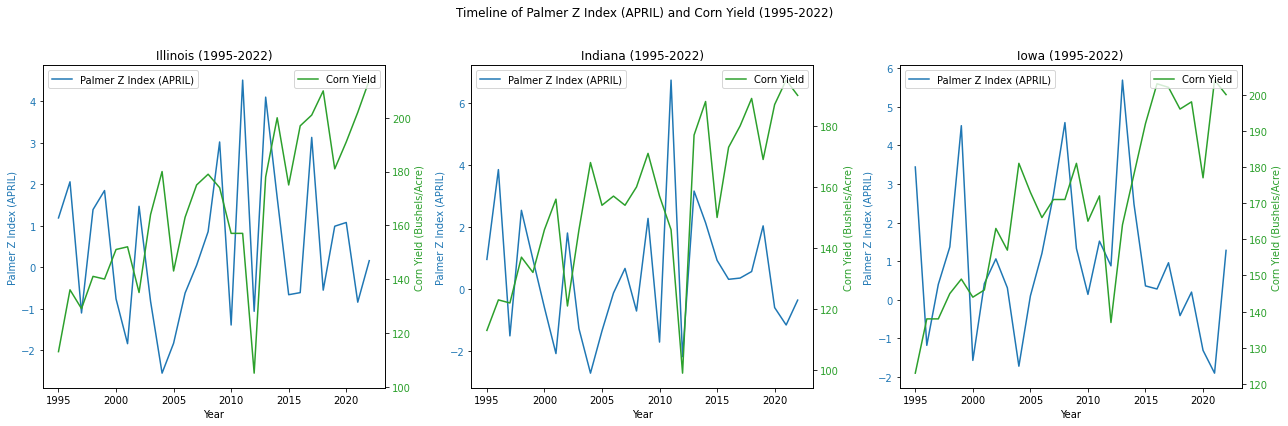

In [32]:
#Creating line charts to show relationship between Palmer Z Index and Corn Yield (planting season)
#storing the string 'APRIL' and creating a figure for the subplots
april = 'APRIL'
fig = plt.figure(figsize=(18, 6))

#plot for Illinois planting season
#first create a subplot in a 1-row, 3-column layout
#take the filtered Illinois merged data and plot the Palmer Z Index against the years, using a blue line
#label axis, ticks, add a legend and a title
#next create a twin y-axis for the subplot (Corn Yield) and perform same process with labels
#this is plotted against the years, using a green line
illinois_subplot_april_x = fig.add_subplot(1, 3, 1)
illinois_merged_data = merged_data[merged_data['DIVISION'] == 'Illinois']
illinois_subplot_april_x.plot(illinois_merged_data['YEAR'], illinois_merged_data[april], label=f'Palmer Z Index ({april})', color='tab:blue')
illinois_subplot_april_x.set_xlabel('Year')
illinois_subplot_april_x.set_ylabel(f'Palmer Z Index ({april})', color='tab:blue')
illinois_subplot_april_x.tick_params(axis='y', labelcolor='tab:blue')
illinois_subplot_april_x.legend(loc='upper left')
illinois_subplot_april_x.set_title('Illinois (1995-2022)')
illinois_subplot_april_y = illinois_subplot_april_x.twinx()
illinois_subplot_april_y.plot(illinois_merged_data['YEAR'], illinois_merged_data['Value'], label='Corn Yield', color='tab:green')
illinois_subplot_april_y.set_ylabel('Corn Yield (Bushels/Acre)', color='tab:green')
illinois_subplot_april_y.tick_params(axis='y', labelcolor='tab:green')
illinois_subplot_april_y.legend(loc='upper right')

#plot for Indiana planting season (same steps as Illinois)
indiana_subplot_april_x = fig.add_subplot(1, 3, 2)
indiana_merged_data = merged_data[merged_data['DIVISION'] == 'Indiana']
indiana_subplot_april_x.plot(indiana_merged_data['YEAR'], indiana_merged_data[april], label=f'Palmer Z Index ({april})', color='tab:blue')
indiana_subplot_april_x.set_xlabel('Year')
indiana_subplot_april_x.set_ylabel(f'Palmer Z Index ({april})', color='tab:blue')
indiana_subplot_april_x.tick_params(axis='y', labelcolor='tab:blue')
indiana_subplot_april_x.legend(loc='upper left')
indiana_subplot_april_x.set_title('Indiana (1995-2022)')
indiana_subplot_april_y = indiana_subplot_april_x.twinx()
indiana_subplot_april_y.plot(indiana_merged_data['YEAR'], indiana_merged_data['Value'], label='Corn Yield', color='tab:green')
indiana_subplot_april_y.set_ylabel('Corn Yield (Bushels/Acre)', color='tab:green')
indiana_subplot_april_y.tick_params(axis='y', labelcolor='tab:green')
indiana_subplot_april_y.legend(loc='upper right')

#plot for Iowa planting season (same steps as Illinois)
iowa_subplot_april_x = fig.add_subplot(1, 3, 3)
iowa_merged_data = merged_data[merged_data['DIVISION'] == 'Iowa']
iowa_subplot_april_x.plot(iowa_merged_data['YEAR'], iowa_merged_data[april], label=f'Palmer Z Index ({april})', color='tab:blue')
iowa_subplot_april_x.set_xlabel('Year')
iowa_subplot_april_x.set_ylabel(f'Palmer Z Index ({april})', color='tab:blue')
iowa_subplot_april_x.tick_params(axis='y', labelcolor='tab:blue')
iowa_subplot_april_x.legend(loc='upper left')
iowa_subplot_april_x.set_title('Iowa (1995-2022)')
iowa_subplot_april_y = iowa_subplot_april_x.twinx()
iowa_subplot_april_y.plot(iowa_merged_data['YEAR'], iowa_merged_data['Value'], label='Corn Yield', color='tab:green')
iowa_subplot_april_y.set_ylabel('Corn Yield (Bushels/Acre)', color='tab:green')
iowa_subplot_april_y.tick_params(axis='y', labelcolor='tab:green')
iowa_subplot_april_y.legend(loc='upper right')

#main title
plt.suptitle(f'Timeline of Palmer Z Index ({april}) and Corn Yield (1995-2022)')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

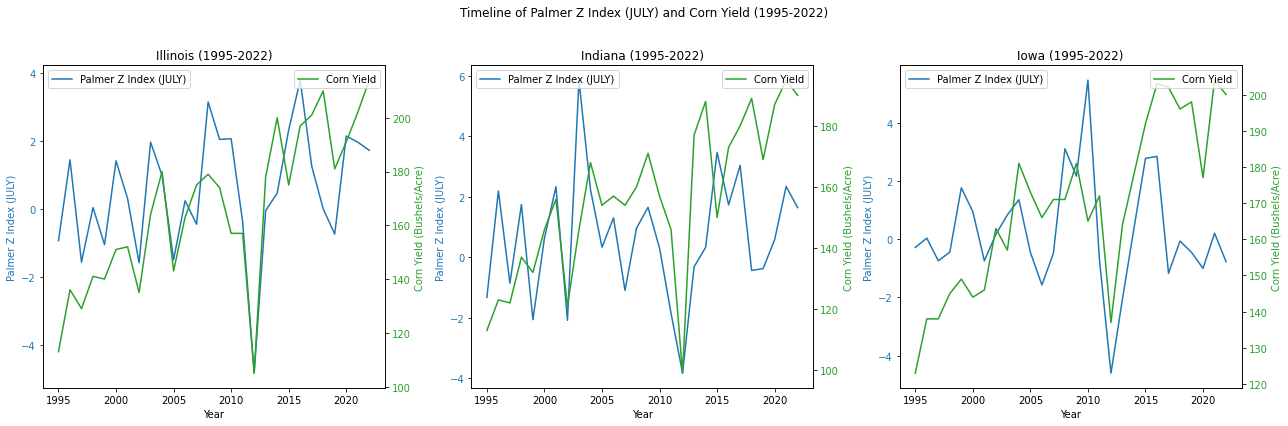

In [33]:
#Creating line charts to show relationship between Palmer Z Index and Corn Yield (growing season)
#storing the string 'JULY' and creating a figure for the subplots
july = 'JULY'
fig = plt.figure(figsize=(18, 6))

#plot for Illinois growing season
#first create a subplot in a 1-row, 3-column layout
#take the filtered Illinois merged data and plot the Palmer Z Index against the years, using a blue line
#label axis, ticks, add a legend and a title
#next create a twin y-axis for the subplot (Corn Yield) and perform same process with labels
#this is plotted against the years, using a green line
illinois_subplot_july_x = fig.add_subplot(1, 3, 1)
filtered_data_for_plot = merged_data[merged_data['DIVISION'] == 'Illinois']
illinois_subplot_july_x.plot(filtered_data_for_plot['YEAR'], filtered_data_for_plot[july], label=f'Palmer Z Index ({july})', color='tab:blue')
illinois_subplot_july_x.set_xlabel('Year')
illinois_subplot_july_x.set_ylabel(f'Palmer Z Index ({july})', color='tab:blue')
illinois_subplot_july_x.tick_params(axis='y', labelcolor='tab:blue')
illinois_subplot_july_x.legend(loc='upper left')
illinois_subplot_july_x.set_title('Illinois (1995-2022)')
illinois_subplot_july_y = illinois_subplot_july_x.twinx()
illinois_subplot_july_y.plot(filtered_data_for_plot['YEAR'], filtered_data_for_plot['Value'], label='Corn Yield', color='tab:green')
illinois_subplot_july_y.set_ylabel('Corn Yield (Bushels/Acre)', color='tab:green')
illinois_subplot_july_y.tick_params(axis='y', labelcolor='tab:green')
illinois_subplot_july_y.legend(loc='upper right')

#plot for Indiana growing season (same steps as Illinois)
indiana_subplot_july_x = fig.add_subplot(1, 3, 2)
filtered_data_for_plot = merged_data[merged_data['DIVISION'] == 'Indiana']
indiana_subplot_july_x.plot(filtered_data_for_plot['YEAR'], filtered_data_for_plot[july], label=f'Palmer Z Index ({july})', color='tab:blue')
indiana_subplot_july_x.set_xlabel('Year')
indiana_subplot_july_x.set_ylabel(f'Palmer Z Index ({july})', color='tab:blue')
indiana_subplot_july_x.tick_params(axis='y', labelcolor='tab:blue')
indiana_subplot_july_x.legend(loc='upper left')
indiana_subplot_july_x.set_title('Indiana (1995-2022)')
indiana_subplot_july_y = indiana_subplot_july_x.twinx()
indiana_subplot_july_y.plot(filtered_data_for_plot['YEAR'], filtered_data_for_plot['Value'], label='Corn Yield', color='tab:green')
indiana_subplot_july_y.set_ylabel('Corn Yield (Bushels/Acre)', color='tab:green')
indiana_subplot_july_y.tick_params(axis='y', labelcolor='tab:green')
indiana_subplot_july_y.legend(loc='upper right')

#plot for Iowa growing season (same steps as Illinois)
iowa_subplot_july_x = fig.add_subplot(1, 3, 3)
filtered_data_for_plot = merged_data[merged_data['DIVISION'] == 'Iowa']
iowa_subplot_july_x.plot(filtered_data_for_plot['YEAR'], filtered_data_for_plot[july], label=f'Palmer Z Index ({july})', color='tab:blue')
iowa_subplot_july_x.set_xlabel('Year')
iowa_subplot_july_x.set_ylabel(f'Palmer Z Index ({july})', color='tab:blue')
iowa_subplot_july_x.tick_params(axis='y', labelcolor='tab:blue')
iowa_subplot_july_x.legend(loc='upper left')
iowa_subplot_july_x.set_title('Iowa (1995-2022)')
iowa_subplot_july_y = iowa_subplot_july_x.twinx()
iowa_subplot_july_y.plot(filtered_data_for_plot['YEAR'], filtered_data_for_plot['Value'], label='Corn Yield', color='tab:green')
iowa_subplot_july_y.set_ylabel('Corn Yield (Bushels/Acre)', color='tab:green')
iowa_subplot_july_y.tick_params(axis='y', labelcolor='tab:green')
iowa_subplot_july_y.legend(loc='upper right')

#main title
plt.suptitle(f'Timeline of Palmer Z Index ({july}) and Corn Yield (1995-2022)')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

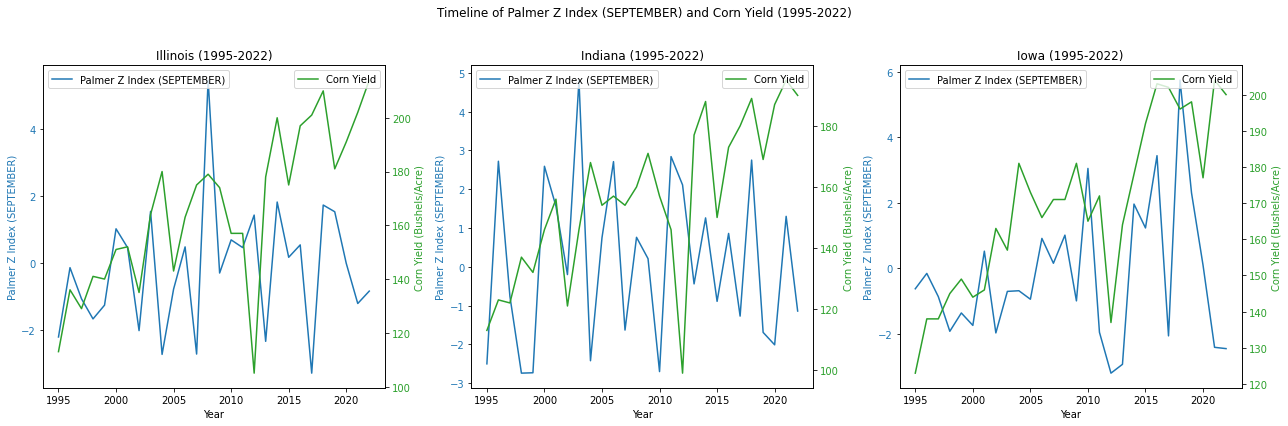

In [34]:
#Creating line charts to show relationship between Palmer Z Index and Corn Yield (harvest season)
#storing the string 'SEPTEMBER' and creating a figure for the subplots
september = 'SEPTEMBER'
fig = plt.figure(figsize=(18, 6))

#plot for Illinois harvest season
#first create a subplot in a 1-row, 3-column layout
#take the filtered Illinois merged data and plot the Palmer Z Index against the years, using a blue line
#label axis, ticks, add a legend and a title
#next create a twin y-axis for the subplot (Corn Yield) and perform same process with labels
#this is plotted against the years, using a green line
illinois_subplot_september_x = fig.add_subplot(1, 3, 1)
filtered_data_for_plot = merged_data[merged_data['DIVISION'] == 'Illinois']
illinois_subplot_september_x.plot(filtered_data_for_plot['YEAR'], filtered_data_for_plot[september], label=f'Palmer Z Index ({september})', color='tab:blue')
illinois_subplot_september_x.set_xlabel('Year')
illinois_subplot_september_x.set_ylabel(f'Palmer Z Index ({september})', color='tab:blue')
illinois_subplot_september_x.tick_params(axis='y', labelcolor='tab:blue')
illinois_subplot_september_x.legend(loc='upper left')
illinois_subplot_september_x.set_title('Illinois (1995-2022)')
illinois_subplot_september_y = illinois_subplot_september_x.twinx()
illinois_subplot_september_y.plot(filtered_data_for_plot['YEAR'], filtered_data_for_plot['Value'], label='Corn Yield', color='tab:green')
illinois_subplot_september_y.set_ylabel('Corn Yield (Bushels/Acre)', color='tab:green')
illinois_subplot_september_y.tick_params(axis='y', labelcolor='tab:green')
illinois_subplot_september_y.legend(loc='upper right')

#plot for Indiana harvest season (same steps as Illinois)
indiana_subplot_september_x = fig.add_subplot(1, 3, 2)
filtered_data_for_plot = merged_data[merged_data['DIVISION'] == 'Indiana']
indiana_subplot_september_x.plot(filtered_data_for_plot['YEAR'], filtered_data_for_plot[september], label=f'Palmer Z Index ({september})', color='tab:blue')
indiana_subplot_september_x.set_xlabel('Year')
indiana_subplot_september_x.set_ylabel(f'Palmer Z Index ({september})', color='tab:blue')
indiana_subplot_september_x.tick_params(axis='y', labelcolor='tab:blue')
indiana_subplot_september_x.legend(loc='upper left')
indiana_subplot_september_x.set_title('Indiana (1995-2022)')
indiana_subplot_september_y = indiana_subplot_september_x.twinx()
indiana_subplot_september_y.plot(filtered_data_for_plot['YEAR'], filtered_data_for_plot['Value'], label='Corn Yield', color='tab:green')
indiana_subplot_september_y.set_ylabel('Corn Yield (Bushels/Acre)', color='tab:green')
indiana_subplot_september_y.tick_params(axis='y', labelcolor='tab:green')
indiana_subplot_september_y.legend(loc='upper right')

#plot for Iowa harvest season (same steps as Illinois)
iowa_subplot_september_x = fig.add_subplot(1, 3, 3)
filtered_data_for_plot = merged_data[merged_data['DIVISION'] == 'Iowa']
iowa_subplot_september_x.plot(filtered_data_for_plot['YEAR'], filtered_data_for_plot[september], label=f'Palmer Z Index ({september})', color='tab:blue')
iowa_subplot_september_x.set_xlabel('Year')
iowa_subplot_september_x.set_ylabel(f'Palmer Z Index ({september})', color='tab:blue')
iowa_subplot_september_x.tick_params(axis='y', labelcolor='tab:blue')
iowa_subplot_september_x.legend(loc='upper left')
iowa_subplot_september_x.set_title('Iowa (1995-2022)')
iowa_subplot_september_y = iowa_subplot_september_x.twinx()
iowa_subplot_september_y.plot(filtered_data_for_plot['YEAR'], filtered_data_for_plot['Value'], label='Corn Yield', color='tab:green')
iowa_subplot_september_y.set_ylabel('Corn Yield (Bushels/Acre)', color='tab:green')
iowa_subplot_september_y.tick_params(axis='y', labelcolor='tab:green')
iowa_subplot_september_y.legend(loc='upper right')

#main title
plt.suptitle(f'Timeline of Palmer Z Index ({september}) and Corn Yield (1995-2022)')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

## Line Charts Observations
First glance looking at all these visualizations, we notice a few where the Palmer Z Index and Corn Yield produce similar shapes. In the July graphs, there seems to be a relationship between the two plotted variables and the severe drought in the 2012 growing season, that was shown in the heatmaps, is very evident. Both the index and the yield dropped significantly compared to other years. In relation to the extreme wetness in 2011 planting season, the corn yield does not spike up like the index did. There does not seem to be a relationship there. This will require further investigation.

## Calculating Correlation, P-Values and Significance
Next, we will take these inferences from the line charts and confirm them with further statistical analysis. Firstly, we wrote a function in python to calculate the Pearson correlation coefficient to test the strength and direction of the linear relationship between the two variables. These being the Palmer Z indices and corn yield for each month and state. Significance and p-value functions were also created for these and used to calculate the statistical significance of the Pearson correlation coefficient. This was done by using a t-statistic, and a threshold of α=0.05. 

In [35]:
#specifying the divisions and months we are looking at from merged dataframe
divisions = ['Illinois', 'Indiana', 'Iowa']
months= ['APRIL', 'JULY', 'SEPTEMBER']

#Function to calculate Pearson correlation coefficient (r) using its formula and approximate the p-value
#for two lists of numbers x and y
def r_and_p(x, y):
    n = len(x)
    sum_x = sum(x)
    sum_y = sum(y)
    sum_x_squared = sum([xi**2 for xi in x])
    sum_y_squared = sum([yi**2 for yi in y])
    sum_xy = sum([xi * yi for xi, yi in zip(x, y)])
    
    #calculates r
    numerator = n * sum_xy - sum_x * sum_y
    denominator = ((n * sum_x_squared - sum_x**2) * (n * sum_y_squared - sum_y**2))**0.5
    r = numerator / denominator
    
    #calculates t-statistic
    t_statistic = r * ((n - 2) / (1 - r**2))**0.5
    
    #calculates p-value
    p_value = 2 * (1 - 0.5 * (1 + math.erf(t_statistic / (2**0.5))))
    
    
    return r, p_value

#Function to calculate correlations for multiple months
#iterates over a list of months and for each month 
#calculates r and p-value between the Palmer Z Index and Corn Yield for a specific state
#returns results in dictionary
def r_and_p_for_months(data, months, division):
    results = {}
    filtered_data_for_corr = data[data['DIVISION'] == division]
    for month in months:
        r, p_value = r_and_p(
            filtered_data_for_corr[month].tolist(), 
            filtered_data_for_corr['Value'].tolist()
        )
        results[month] = {'Correlation Coefficient': r, 'p-value': p_value}
    return results

#Function to indicate whether the p-value is less than 0.05 ("Significant") or not ("Not Significant")
def significance(df):
    df['Significance'] = df['p-value'].apply(lambda x: 'Significant' if x < 0.05 else 'Not Significant')
    return df

#Loop that iterates through each state and specified month and calculates the correlation and p-value from previous functions
#these values stored in dictionary
r_and_p_months_results = {}
for state in divisions:
    r_and_p_months_results[state] = r_and_p_for_months(merged_data, months, state)

#List of dictionaries created with looping to insert into pandas dataframe
data_for_df = []
for division in divisions:
    for month in months:
        data_for_df.append({
            "Division": division,
            "Month": month,
            "Correlation Coefficient": round(r_and_p_months_results[division][month]['Correlation Coefficient'], 4),
            "p-value": round(r_and_p_months_results[division][month]['p-value'], 4)
        })

#inputing list of dictionaries into pandas dataframe 
#using the significant() function to determine if p-value for each row is significant or not
#add this as new column then displaying results
correlation_df = pd.DataFrame(data_for_df)
correlation_df = significance(correlation_df)
correlation_df


,Division,Month,Correlation Coefficient,p-value,Significance
0,Illinois,APRIL,0.0667,0.7331,Not Significant
1,Illinois,JULY,0.6329,0.0000,Significant
2,Illinois,SEPTEMBER,0.1027,0.5986,Not Significant
3,Indiana,APRIL,-0.0424,1.1714,Not Significant
4,Indiana,JULY,0.4113,0.0214,Significant
5,Indiana,SEPTEMBER,-0.0245,1.0993,Not Significant
6,Iowa,APRIL,-0.2159,1.7405,Not Significant
7,Iowa,JULY,0.2196,0.2512,Not Significant
8,Iowa,SEPTEMBER,0.3168,0.0886,Not Significant


## Statistical Inferences
From the results we can make some inferences about the data. During the planting and harvesting process, yield is not significant with Palmer Z Index, however, during the growing season, it is significant in two of the three states. This concludes that during the planting and harvesting months, severe rain and droughts is most likely not a factor when it comes to corn yield, however, a factor when it comes to the growing months. This is supported by its strong positive correlations and also in the line charts where we see a massive drop in the yield when there was a severe drought in the 2012 growing season.

The analysis provided insights into the relationship between drought and rain, as measured by Palmer Z indices, and corn yield in the three I’s. While some months showed a statistically significant relationship, others did not, suggesting that further study is needed to understand the various factors affecting corn yield.


# Guiding Question Two
## How has the efficiency of corn production progressed over time?

First, we will be loading all the datasets that we will be using to answer this question and gain a clear understanding of the format and structure of the datasets. The source of these datasets has come from the United States Department of Agriculture National Agricultural Statistics Service. NASS has developed a database called Quick Stats that gives the public access to the agricultural data they publish. 

A link to the database tool is here: https://quickstats.nass.usda.gov/
A glossary of abbreviations and acronyms used in quick stats can be found here: https://quickstats.nass.usda.gov/src/glossary.pdf
Lastly, a link to their parameters definition documentation can be found here: https://quickstats.nass.usda.gov/param_define

Let us proceed by creating our data frame objects and reading them into Python.

In [36]:
yield_peracre = pd.read_csv("Yieldperacrebig3.csv")
plant_peracre = pd.read_csv("plantsperacre.csv")

# First let's determine the general shape of the data 

print(yield_peracre.shape)
print(plant_peracre.shape)

# next let's check what data types we are working with

print("DataFrame Description")
print("----------------------")
print("yield_peracre:\n", yield_peracre.dtypes)
print()
print("plants_peracre:\n", plant_peracre.dtypes)

(1061, 21)
(142, 21)
DataFrame Description
----------------------
yield_peracre:
 Program              object
Year                  int64
Period               object
Week Ending         float64
Geo Level            object
State                object
State ANSI            int64
Ag District         float64
Ag District Code    float64
County              float64
County ANSI         float64
Zip Code            float64
Region              float64
watershed_code        int64
Watershed           float64
Commodity            object
Data Item            object
Domain               object
Domain Category      object
Value               float64
CV (%)              float64
dtype: object

plants_peracre:
 Program              object
Year                  int64
Period               object
Week Ending         float64
Geo Level            object
State                object
State ANSI            int64
Ag District         float64
Ag District Code    float64
County              float64
County ANSI       

In [37]:
yield_peracre

,Program,Year,Period,Week Ending,Geo Level,State,State ANSI,Ag District,Ag District Code,County,...,Zip Code,Region,watershed_code,Watershed,Commodity,Data Item,Domain,Domain Category,Value,CV (%)
0,SURVEY,2023,YEAR,NaN,STATE,ILLINOIS,17,NaN,NaN,NaN,...,NaN,NaN,0,NaN,CORN,"CORN, GRAIN - YIELD, MEASURED IN BU / ACRE",TOTAL,NOT SPECIFIED,198.0,NaN
1,SURVEY,2023,YEAR,NaN,STATE,INDIANA,18,NaN,NaN,NaN,...,NaN,NaN,0,NaN,CORN,"CORN, GRAIN - YIELD, MEASURED IN BU / ACRE",TOTAL,NOT SPECIFIED,194.0,NaN
2,SURVEY,2023,YEAR,NaN,STATE,IOWA,19,NaN,NaN,NaN,...,NaN,NaN,0,NaN,CORN,"CORN, GRAIN - YIELD, MEASURED IN BU / ACRE",TOTAL,NOT SPECIFIED,200.0,NaN
3,SURVEY,2023,YEAR - AUG FORECAST,NaN,STATE,ILLINOIS,17,NaN,NaN,NaN,...,NaN,NaN,0,NaN,CORN,"CORN, GRAIN - YIELD, MEASURED IN BU / ACRE",TOTAL,NOT SPECIFIED,201.0,NaN
4,SURVEY,2023,YEAR - AUG FORECAST,NaN,STATE,INDIANA,18,NaN,NaN,NaN,...,NaN,NaN,0,NaN,CORN,"CORN, GRAIN - YIELD, MEASURED IN BU / ACRE",TOTAL,NOT SPECIFIED,195.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1056,SURVEY,1867,YEAR,NaN,STATE,INDIANA,18,NaN,NaN,NaN,...,NaN,NaN,0,NaN,CORN,"CORN, GRAIN - YIELD, MEASURED IN BU / ACRE",TOTAL,NOT SPECIFIED,29.0,NaN
1057,SURVEY,1867,YEAR,NaN,STATE,IOWA,19,NaN,NaN,NaN,...,NaN,NaN,0,NaN,CORN,"CORN, GRAIN - YIELD, MEASURED IN BU / ACRE",TOTAL,NOT SPECIFIED,41.0,NaN
1058,SURVEY,1866,YEAR,NaN,STATE,ILLINOIS,17,NaN,NaN,NaN,...,NaN,NaN,0,NaN,CORN,"CORN, GRAIN - YIELD, MEASURED IN BU / ACRE",TOTAL,NOT SPECIFIED,29.0,NaN
1059,SURVEY,1866,YEAR,NaN,STATE,INDIANA,18,NaN,NaN,NaN,...,NaN,NaN,0,NaN,CORN,"CORN, GRAIN - YIELD, MEASURED IN BU / ACRE",TOTAL,NOT SPECIFIED,36.5,NaN


Yield measured by BU/Acre is the first feature we will be accessing as a measurement of efficiency. We can see the data spans from 1866 to 2023. The only columns we need for our exploration and to create the appropriate visualizations are the "Year", "Period", "State" and "Value" columns. We need the "Year" as we are dealing with a time series to see how the efficiency of corn farming has changed over time. We need the Period column because there are forecasts in this column and it needs to be filtered to only include observed values of BU/Acre. To facilitate comparisons among different regions, we require the 'State' column. This will allow us to categorize the BU/Acre data by state and contrast their performances. Lastly, we need the value column which contains the key variable of interest- BU/Acre as a quantity serving as our metric of efficiency. The rest of the columns in the data frame can be dropped as they are not required. Now we have identified how we need to wrangle and clean the data to create our first visualization in our data exploration.

In [38]:
print(str(plant_peracre.loc[0,"Data Item"]))
plant_peracre

CORN, GRAIN - PLANT POPULATION, MEASURED IN PLANTS / ACRE


,Program,Year,Period,Week Ending,Geo Level,State,State ANSI,Ag District,Ag District Code,County,...,Zip Code,Region,watershed_code,Watershed,Commodity,Data Item,Domain,Domain Category,Value,CV (%)
0,SURVEY,2023,YEAR,NaN,STATE,IOWA,19,NaN,NaN,NaN,...,NaN,NaN,0,NaN,CORN,"CORN, GRAIN - PLANT POPULATION, MEASURED IN PL...",TOTAL,NOT SPECIFIED,"32,250",NaN
1,SURVEY,2023,YEAR - SEP FORECAST,NaN,STATE,IOWA,19,NaN,NaN,NaN,...,NaN,NaN,0,NaN,CORN,"CORN, GRAIN - PLANT POPULATION, MEASURED IN PL...",TOTAL,NOT SPECIFIED,"32,250",NaN
2,SURVEY,2022,YEAR,NaN,STATE,IOWA,19,NaN,NaN,NaN,...,NaN,NaN,0,NaN,CORN,"CORN, GRAIN - PLANT POPULATION, MEASURED IN PL...",TOTAL,NOT SPECIFIED,"31,600",NaN
3,SURVEY,2022,YEAR - NOV FORECAST,NaN,STATE,IOWA,19,NaN,NaN,NaN,...,NaN,NaN,0,NaN,CORN,"CORN, GRAIN - PLANT POPULATION, MEASURED IN PL...",TOTAL,NOT SPECIFIED,"31,600",NaN
4,SURVEY,2022,YEAR - OCT FORECAST,NaN,STATE,IOWA,19,NaN,NaN,NaN,...,NaN,NaN,0,NaN,CORN,"CORN, GRAIN - PLANT POPULATION, MEASURED IN PL...",TOTAL,NOT SPECIFIED,"31,550",NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137,SURVEY,1967,YEAR,NaN,STATE,IOWA,19,NaN,NaN,NaN,...,NaN,NaN,0,NaN,CORN,"CORN, GRAIN - PLANT POPULATION, MEASURED IN PL...",TOTAL,NOT SPECIFIED,"16,000",NaN
138,SURVEY,1966,YEAR,NaN,STATE,IOWA,19,NaN,NaN,NaN,...,NaN,NaN,0,NaN,CORN,"CORN, GRAIN - PLANT POPULATION, MEASURED IN PL...",TOTAL,NOT SPECIFIED,"15,800",NaN
139,SURVEY,1965,YEAR,NaN,STATE,IOWA,19,NaN,NaN,NaN,...,NaN,NaN,0,NaN,CORN,"CORN, GRAIN - PLANT POPULATION, MEASURED IN PL...",TOTAL,NOT SPECIFIED,"15,000",NaN
140,SURVEY,1964,YEAR,NaN,STATE,IOWA,19,NaN,NaN,NaN,...,NaN,NaN,0,NaN,CORN,"CORN, GRAIN - PLANT POPULATION, MEASURED IN PL...",TOTAL,NOT SPECIFIED,"14,300",NaN


The next feature we will be utilizing to deepen our analysis is the number of plants per acre. We're focusing on Iowa because it's a top-three corn producer, offering a clear snapshot of leading production practices. As the data item column has a long string value that gets truncated in the pandas data frame we print it to ensure we know exactly what variable we are dealing with. It is indeed plants/per acre that we are after. The wrangling of this data frame is similar to the yield_per acre data frame. Again we will be extracting the "Year" column for our time series. The "Period" column as we again need to filter out the forecasts and the "Value" column for the actual number of plants per acre. Luckily the structured data from NASS follows a consistent format so we will be able to reuse and modify much of our code for cleaning and wrangling. 

Let's proceed with the wrangling and the first visualization, then we will see some of the more nuanced issues that present themselves and the steps we take to derive our yield per plant metric that will be combined with the plants per acre for our second visualization.

      Year Period     State  Value
0     2023   YEAR  ILLINOIS  198.0
9     2022   YEAR  ILLINOIS  214.0
24    2021   YEAR  ILLINOIS  202.0
39    2020   YEAR  ILLINOIS  191.0
54    2019   YEAR  ILLINOIS  181.0
...    ...    ...       ...    ...
1046  1870   YEAR  ILLINOIS   40.0
1049  1869   YEAR  ILLINOIS   23.5
1052  1868   YEAR  ILLINOIS   34.2
1055  1867   YEAR  ILLINOIS   27.0
1058  1866   YEAR  ILLINOIS   29.0

[158 rows x 4 columns]
      Year Period State  Value
2     2023   YEAR  IOWA  200.0
11    2022   YEAR  IOWA  200.0
26    2021   YEAR  IOWA  204.0
41    2020   YEAR  IOWA  177.0
56    2019   YEAR  IOWA  198.0
...    ...    ...   ...    ...
1048  1870   YEAR  IOWA   40.0
1051  1869   YEAR  IOWA   33.5
1054  1868   YEAR  IOWA   40.5
1057  1867   YEAR  IOWA   41.0
1060  1866   YEAR  IOWA   32.0

[158 rows x 4 columns]


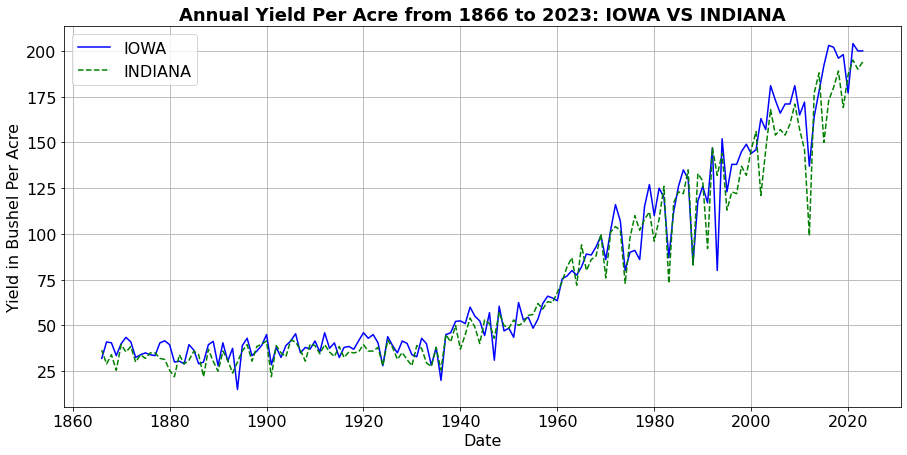

In [39]:
# Going to start looking at efficiency by charting a time series of yield per acre in the big 3 Illinois, Indiana, and Iowa
# note: initially Illinois was also plotted to represent the big 3 for project consistency but the plot looked too crowded and the additional 
# state did not add any value to the main message

# dropping unneccsary columns
yield_peracre = yield_peracre.drop(columns = ["Data Item","County ANSI","Program","Week Ending","Geo Level","State ANSI","Ag District", "Ag District Code","County","Zip Code","Region","watershed_code","Watershed","Commodity","Domain","Domain Category","CV (%)"])

# slicing to only select observed values (ommiting forecasts)
yield_peracre = yield_peracre.loc[yield_peracre["Period"] == "YEAR"]


# creating seperate data frames for each of the three states

illinois = yield_peracre.loc[yield_peracre["State"] == "ILLINOIS"]
indiana = yield_peracre.loc[yield_peracre["State"] == "INDIANA"]
iowa = yield_peracre.loc[yield_peracre["State"] == "IOWA"]

# printing to view sliced dataframes and ensure we have consitent dates and formatting for plotting 
print(illinois)
print(iowa)

# creating the plot, we're using only one 'Year' column for the x-axis, as the years for both Illinois and Iowa are identical.

fig, ax = plt.subplots(figsize=(15, 7))
ax.plot(iowa["Year"],iowa["Value"],label = "IOWA",color = "blue")
ax.plot(iowa["Year"],indiana["Value"],linestyle='dashed',label = "INDIANA",color = "green")
plt.title("Annual Yield Per Acre from 1866 to 2023: IOWA VS INDIANA",fontsize = 18, fontweight = "bold")
plt.xlabel("Date",fontsize = 16)
plt.ylabel("Yield in Bushel Per Acre",fontsize = 16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax.legend(loc="upper left",fontsize = 16)
ax.grid(True)
plt.savefig("Yield Per Acre: Indiana vs Iowa")
plt.show()


Alas, our first visualization, and an interesting one at that. The line plot clearly portrays the improved efficiency in the production of corn over the last 157 years. This is a nice direct measurement of efficiency as the acre does not change. A few things to note beyond the obvious upward trend of the graph:

1) Between 1940 and 1960 the rate of acceleration in the yield in BU/Acre begins to take off and appears to maintain an impressive growth rate till the present. Especially when we compare this to the initial approx 80-100 years of the graph. We did attempt to research if there were significant changes that took place in the agricultural industry during this window but were not able to pinpoint anything that may be responsible for such a catalyst in growth. 

    We can only hypothesize that continued advancements in corn farming research, technology, and processes led to this increased level of efficiency. A more       comprehensive analysis of farming history may provide an answer to this question but is not necessarily relevant to the scope of this project. 
 
2) The yield in BU/Acre can be quite volatile. Notice that regardless of the time frame the spikes and dips in production can fluctuate widely from one year to the next. While we cannot assert what is causing these fluctuations from this image we can infer that corn must be sensitive to other variables that influence its yield, things like weather, global demand and supply, etc.

3) The increase in efficiency is enjoyed by both Indiana and Iowa which speaks to the fact that these improvements are industry-wide and are not a result of any kind of specialization or competitive advantage particular to these states. While there are certain factors that differentiate these states and others found in the corn belt who are world leaders in the production of corn, we have looked at data for other counties and states and the yield in BU/Acre gains are comparable.

From this analysis, the next logical question we sought out to answer was - what is driving this increase in efficiency? After doing some research and looking at what data was available to use on the NASS quick stats database we discovered that the plant_peracre dataset discussed earlier would be very useful for us. We realized that if we took the yield/acre divided by the plant per acre over the same time frame in the two datasets we would be able to derive the yield per plant in a particular state. From there we can create a side-by-side visualization that will be very useful for understanding what is going on in the acre with regards to the plants themselves.

The first steps of the wrangling are as described when we introduced the yield_per plant data set but some additional steps must be taken to obtain the yield per plant. Note that the value column in this data set is a string (shown below) so we must convert this to a float or int for our analysis. Moreover, while our yield in Bu/Acre dataset dates back to 1866 (including Iowa) our dataset for plants per acre dates back to 1963. So we will have to slice the Iowa yield in BU/Acre data frame to 1963 - 2023. With this completed we can insert a new variable into our plant per acre data frame that contains the yield per plant and finally multiply that figure by 56 to get the yield per plant in lbs as opposed to BU. This way the audience has a slightly enhanced ability to conceptualize the measurement. Please see the code below for the work.

In [40]:
print(type(plant_peracre.loc[0,"Value"]))
print((plant_peracre.loc[0,"Value"]))

<class 'str'>
32,250


    Year Period State  Value
0   2023   YEAR  IOWA  32250
1   2022   YEAR  IOWA  31600
2   2021   YEAR  IOWA  31800
3   2020   YEAR  IOWA  31050
4   2019   YEAR  IOWA  30750
..   ...    ...   ...    ...
56  1967   YEAR  IOWA  16000
57  1966   YEAR  IOWA  15800
58  1965   YEAR  IOWA  15000
59  1964   YEAR  IOWA  14300
60  1963   YEAR  IOWA  13600

[61 rows x 4 columns]
    Year Period State  Value
0   2023   YEAR  IOWA  200.0
1   2022   YEAR  IOWA  200.0
2   2021   YEAR  IOWA  204.0
3   2020   YEAR  IOWA  177.0
4   2019   YEAR  IOWA  198.0
..   ...    ...   ...    ...
56  1967   YEAR  IOWA   88.5
57  1966   YEAR  IOWA   89.0
58  1965   YEAR  IOWA   82.0
59  1964   YEAR  IOWA   77.5
60  1963   YEAR  IOWA   80.0

[61 rows x 4 columns]
    Year Period State  Value  yield_perplant
0   2023   YEAR  IOWA  32250        0.347287
1   2022   YEAR  IOWA  31600        0.354430
2   2021   YEAR  IOWA  31800        0.359245
3   2020   YEAR  IOWA  31050        0.319227
4   2019   YEAR  IOWA  30750     

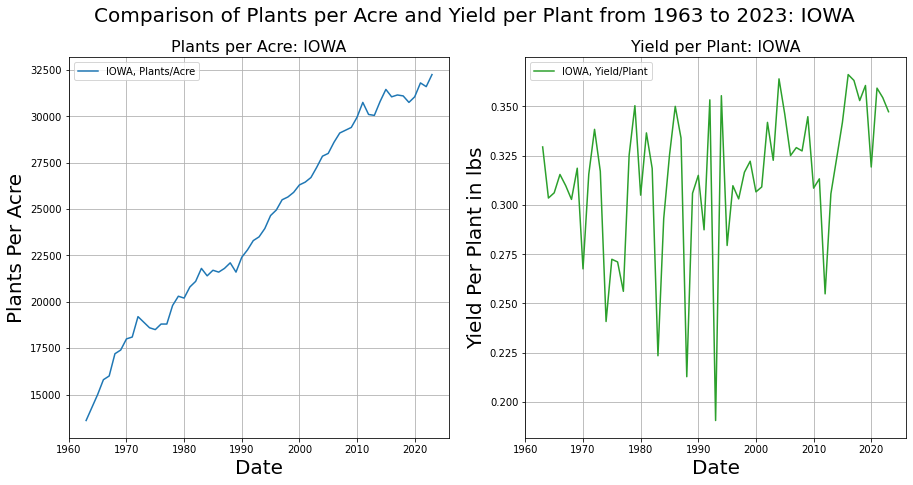

In [41]:
# dropping irrelevant columns 
plant_peracre = plant_peracre.drop(columns = ["Data Item","County ANSI","Program","Week Ending","Geo Level","State ANSI","Ag District", "Ag District Code","County","Zip Code","Region","watershed_code","Watershed","Commodity","Domain","Domain Category","CV (%)"])

# Selecting year to filter out any forecasts
plant_peracre = plant_peracre.loc[plant_peracre["Period"] == "YEAR"]

# converting "Value" column from a string to a float 
plant_peracre["Value"] = pd.to_numeric(plant_peracre["Value"].str.replace(',',''))

# resetting the index
plant_peracre.reset_index(inplace = True)

# filtering Iowa dataframe to include years 1963 - 2023 aligning with the plant_peracre data frame
iowa = iowa.loc[iowa["Year"] >= 1963]

 # resetting indices 
iowa.reset_index(inplace = True)
iowa.drop(columns = ["index"],inplace = True)
plant_peracre.drop(columns = ["index"],inplace = True)
#plant_peracre.drop(columns = ["level_0"],inplace = True)

# making sure plant per acre value column has succesfully been converted to numeric 
print(plant_peracre)

# making sure iowa yield per acre has been succesfully filtered
print(iowa)

# completing the division of columns to derive yield per plant in lbs for iowa and assigning the variable to the plant_peracre data frame
plant_peracre["yield_perplant"] = iowa["Value"].astype(float) / plant_peracre["Value"].astype(float)
plant_peracre["yield_perplant"] = plant_peracre["yield_perplant"] * 56
print(plant_peracre)


# Creating a side by side plot for comparison

a = plant_peracre["Year"]
b = plant_peracre["Value"]
c = plant_peracre["yield_perplant"]

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))

# Left Plot (Plants per Acre)
axs[0].plot(a, b, label='IOWA, Plants/Acre', color='tab:blue')
axs[0].set_title('Plants per Acre: IOWA',fontsize = 16)
axs[0].set_xlabel('Date',fontsize = 20)
axs[0].set_ylabel('Plants Per Acre',fontsize = 20)
axs[0].legend(loc="upper left")
axs[0].grid(True)

# Right Plot (Yield per Plant)
axs[1].plot(a, c, label='IOWA, Yield/Plant', color='tab:green')
axs[1].set_title('Yield per Plant: IOWA', fontsize = 16)
axs[1].set_xlabel('Date',fontsize = 20)
axs[1].set_ylabel('Yield Per Plant in lbs',fontsize = 20)
axs[1].legend(loc="upper left")
axs[1].grid(True)

plt.suptitle('Comparison of Plants per Acre and Yield per Plant from 1963 to 2023: IOWA',fontsize = 20)
plt.savefig("Plants per acre vs yield per plant")
plt.show()

Now we have successfully produced another illuminating visual for our investigation. Let's discuss some of the key takeaways from each plot. 

1) Plants Per Acre - Here we get a very straightforward and clear answer to one of the key drivers in the increase in efficiency spotted from our previous graph. We see a very steady linear trend in the number of plants planted in an acre over the 1963 to 2023 time frame. No doubt this would account for a large portion of the efficiency gains. An interesting follow-up question might be what has allowed for such a significant increase in the number of plants in an acre? If you look closely between the decades plotted you will notice that right as the plants per acre hit 30,000 in 2010 you can visually see the growth rate declining when compared to the majority of the prior decades, and this is no coincidence. According to Mark Licht from Iowa State University maximum corn plant population tends to be near 35,000 plants/acre. He also describes how farmers want to choose a seeding rate that produces economical optimal yield as opposed to maximum yield. For these reasons, we will likely begin to see the yield per plant taper off at this 30,000 - 35,000 threshold. Of course, it's possible advancements in farming technologies could push the bounds of this threshold. 

2) Yield Per Plant - we thought that this metric would give us great insights into looking at the impacts of genetically modified organisms and selective breeding as these are two things that directly affect the plants themselves. One of the questions/opinions we had and that many people not familiar with corn farming might have is something like - "Could it be GMOs responsible for such an increase in efficiency over time? Are the size of the ears so much larger that you get significantly more kernels/yield from the plant?". Well, this graph can address that question. Over the past 63 years, we can see that there does appear to be a slight improvement in the yield of the plant but it is nowhere near large enough to explain the huge increase we see in yield per acre even when viewing it from the same time frame (1963 - 2023). 

3) Comparing the effects of both - We do not want to undermine the importance of this improvement in yield per plant - consider the following hypothetical example. Let's suppose from 1963 and 2023 that today on average you get approx .025 more lbs per plant (.350 - .325). More let's presume that in 2023 you had 30,000 plants in an acre and 1963 15,000 plants in an acre. Lastly, let's assume in 2023 you yielded 200 BU/Acre and in 1963 you yielded 75 BU/Acre. We have derived these figures as rough approximations by looking at the graphs. To be clear we are simply trying to illustrate a point not provide accurate detailed estimates. Using these rough estimates we can break down the effects of increased plant density and increased yield per plant as follows:
   
   change in yield per acre = 200 - 75 = 125 BU/Acre
   
   change in yield per plant = .350 - .325 = .025 lbs
   
   change in plant denisty = 30,000 - 15,000 = 15,000 plants
   
   additional yield per acre due to plant density = 15,000 (add plants) * .325 lbs (1963 yield/plant) = 4,875 lbs of yield/ 56 = 87 BU/Acre, 87 / 125 = 69.6%
   
   additonal yield per acre due to yield increase per plant = 15,000 (1963 # of plants) * .025 (add yield/plant) = 10.4 Bu/Acre = 10.4 / 125 = 8.32%
   
   additional yield per acre = 200 /125 - 1 = 60% 
   
   from this example, we can see that of the 60% increase in yield in BU/Acre approx 70% can be attributed to the increase due to plant density and approx 8.32% can be attributed to the increase in yield per plant. Leaving, 21.68% of the increase of yield in Bu/acre unexplained.
   
   The purpose of this exercise is not to provide hard figures attributing the effects described in the sentence above. But it is reasonable enough given the data to illustrate the potential magnitudes of these two factors on yield in Bu/Acre. As well as highlight that other sources of efficiency gains could be investigated.
   

Responding to Feedback

One of the questions/feedback we received for this research question was as follows - "One area I wanted to point out is the variability in yield per plant changing over time (particularly before the 2000s), and if this was a result of GMO seed being resistant to severe weather, etc. May be an area worth exploring outside the project scope."

This person made a fantastic observation and truthfully we did not even notice the reduction in variance spotted around the 2000 mark probably due to the very low yield per plant in 2012 caused by the severe drought confirmed by our weather data. However, if you look at the yield/plant graph you will notice that at about 1995 the yield/plant appears to become much less volatile than when comparing it to pre-1995. We looked into the question and found something very interesting. 

In 1996 the first GM-engineered crops were introduced to corn farming (Niederhuber, 2015). The first commercial product was something known as a Bt (Bacillus thuringiensis) based biopesticide (Niederhuber, 2015). This Bt gene is a bacteria that is poisonous to caterpillars (Bessin, 2019). Caterpillars can be problematic for corn plants as these larvae will bore into the plant causing damage (Bessin, 2019). The Bt endotoxin is considered safe for humans and generally does not harm other insects such as beetles, flies, bees, and wasps (Bessin, 2019). Today 85% of corn crops in the United States contain the bt gene (Niederhuber, 2015). This modification to corn essentially eliminated the use of pesticides (Niederhuber, 2015).

In 1998 the first glyphosate-resistant corn product commonly called "round-up ready" became available ("Herbicide tolerance," n.d.). These are also known as Herbicide-resistant crops (HT crops). Glyphosate is a herbicide that farmers apply to their crops to kill weeds (Wilkerson, 2015). But the problem was that these herbicides would also kill the corn plant (Wilkerson, 2015). A gene from Agrobacteria was engineered into the plant making it resistant to this herbicide (Wilkerson, 2015).According to the USDA, today about 85% of corn crops also contain this GM and most crops are stacking Ht and Bt together. While the Bt gene dramatically reduced pesticide use, Ht crops have increased the use of herbicides and created the issue of "super weeds" which are glyphosate-resistant weeds(Wilkerson, 2015).

We were able to find the data on pesticide and herbicide application in Illinois, Indiana, and Iowa. The data is consistent with what we found in the research. 
Please the charts below.

In [42]:
def create_trace(x, y, name, color):
    return go.Scatter(
        x=x, y=y,
        mode='lines+markers',
        name=name,
        line=dict(color=color, width=4, dash='solid'),
        marker=dict(size=8)
    )

tr_color1 = 'rgba(0, 255, 255, 1)' # Fluorescent Cyan Neon
tr_color2 = 'rgba(255, 255, 0, 1)' # Fluorescent Yellow Neon


# Create subplots with 3 rows and 1 column
fig = make_subplots(rows=3, cols=1, subplot_titles=("Illinois", "Indiana", "Iowa"),
                    specs=[[{"secondary_y": True}], [{"secondary_y": True}], [{"secondary_y": True}]])

divisions = [11, 12, 13]

# Loop through each division
for i, div in enumerate(divisions, start=1):
    # Filter data by division
    filtered_df = herb_year_division[herb_year_division['DIVISION'] == div]
    
    # Create neon-like traces for Nitrogen and Yield Per Plant
    trace1 = create_trace(herb_year_division['YEAR'], herb_year_division['Value'], 'Herbicide Applied', tr_color1)
    trace2 = create_trace(insect_year_division['YEAR'], insect_year_division['Value'], 'Insecticide Applied', tr_color2)

    
    # Add traces to subplot
    fig.add_trace(trace1, row=i, col=1)
    fig.add_trace(trace2, row=i, col=1, secondary_y=True)

# Update layout for a modern look
fig.update_layout(
    margin=dict(l=100, r=100, b=30, t=50),
    height=600, width=900,
    plot_bgcolor='rgba(40, 40, 40, 1)',
    paper_bgcolor='rgba(40, 40, 40, 1)',
    font=dict(color='white', family="Arial, sans-serif"),
    legend=dict(
        x=1,
        y=0.7,
        traceorder="normal",
        orientation="v",
        yanchor="middle"
    )
)
for i in range(1, 4):
    fig.update_xaxes(
        gridcolor='rgba(60, 60, 60, 1)',
        title='Year',
        row=i, col=1
    )
    fig.update_yaxes(
        gridcolor='rgba(0, 255, 255, 0.4)',
        title='Yeild (lbs)',
        row=i, col=1
    )
    fig.update_yaxes(
        gridcolor='rgba(255, 255, 0, 0.4)',
        title='N Applied (lbs)',
        row=i, col=1,
        secondary_y=True
    )
# Show plot
fig.show()

To address this person's question we will modify our data frame to be split into a pre GM corn and post GM corn time frame. Then we will compute the means and standard deviations of each period and plot them on a histogram with a shared axis so we can compare their distributions. Please see the work below.

    Year  yield_perplant
28  1995        0.279432
29  1994        0.355407
30  1993        0.190638
31  1992        0.353305
32  1991        0.287368
    Year  yield_perplant
23  2000        0.306616
24  1999        0.322162
25  1998        0.316569
26  1997        0.303059
27  1996        0.309739


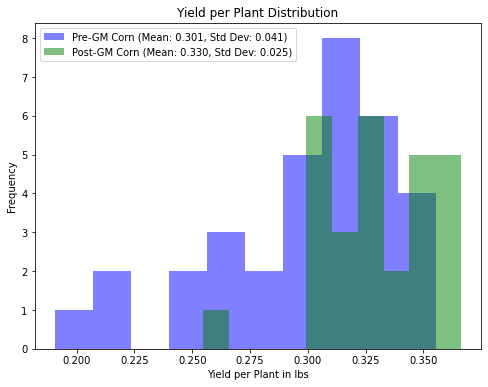

In [43]:
# subsetting yield_perplant to only contain year and yield per plant
yield_perplant = plant_peracre[["Year","yield_perplant"]]
yield_perplant

# creating time frames for pre GM corn and post GM corn
pre_gm = yield_perplant.loc[yield_perplant["Year"] <= 1995]
print(pre_gm.head())
post_gm = yield_perplant.loc[yield_perplant["Year"] > 1995]
print(post_gm.tail())


# Calculate the means and standard deviations of pre_gm and post_gm
pre_bt_mean = pre_gm['yield_perplant'].mean()
post_bt_mean = post_gm['yield_perplant'].mean()
pre_bt_std = pre_gm['yield_perplant'].std()
post_bt_std = post_gm['yield_perplant'].std()

#plot the histograms 
fig, ax = plt.subplots(figsize=(8, 6))


ax.hist(pre_gm['yield_perplant'], bins=10, alpha=0.5, label=f'Pre-GM Corn (Mean: {pre_bt_mean:.3f}, Std Dev: {pre_bt_std:.3f})', color='blue')
ax.hist(post_gm['yield_perplant'], bins=10, alpha=0.5, label=f'Post-GM Corn (Mean: {post_bt_mean:.3f}, Std Dev: {post_bt_std:.3f})', color='green')

ax.set_xlabel('Yield per Plant in lbs')
ax.set_ylabel('Frequency')
ax.set_title('Yield per Plant Distribution')
ax.legend()

plt.savefig("yield per plant histrogram")
plt.show()

Here we can see the distribution of yield per plant in lbs for time frames before GM corn and after GM corn. You can see in the histogram that after the introduction of GM corn, the average yield/plant and the observed values of yield/plant have shifted to the right. In other words, it appears yield/per plant has increased as a result of this change in the industry. We can also see the variance in yields has decreased indicated by the decrease in standard deviation from each period's respective means and by looking at the distribution there are much fewer occurrences of these very low yields/per plant as we see in the case of pre GM corn. Now this is a very simple way to conduct this analysis, some limitations are that first off we have much fewer observations for GM corn as opposed to pre-GM corn. Secondly, we have not factored in the adoption rate of these technologies. If you are interested in these adoption rates and more about GM corn please see this link: https://www.ers.usda.gov/data-products/adoption-of-genetically-engineered-crops-in-the-u-s/recent-trends-in-ge-adoption/

With this in mind, it is still reasonable to conclude that it is very likely given our analysis that GM corn has reduced the variability in yield/per plant to the downside making it more resilient to the adverse effects of insects and weeds. Thereby providing a justified answer to our colleague's question. Note we have not found any research that would indicate that there has been GM to corn that would make it more resistant to weather.

# Guiding Question Three
## How does the price per bushel relate to corn stock and demand for biofuel? 

Price and stock are closely intertwined. When stocks are relatively high, it suggests that supply exceeds demand, which can put downward pressure on prices. Conversely, low stocks may indicate a tighter supply-demand balance, potentially leading to price increases. We will examine this further by looking at accumulated reserves of corn, known as “stock” and price per bushel and see if this relationship holds. Firstly, we will look at corn prices vs corn stock in the US. Additionally, biofuels also play a critical role in the U.S. corn market dynamics. Ethanol production using corn has increased over the years. In the analysis we will look at the relationship between increased global demand for ethanol and price of corn. Both the variables of stock and biofuel exports will give great insights on the fluctuations of corn price.

# Describe datasets: 
Price of corn data set comes from Marcotrends.net. This is an open-source research platform with data on many markets, thus giving us permission to use the data. The tabular data with two rows and 16201 rows in CSV format. The first column is date in the format YYYY-MM-DD and the second column has the price of 1 bushel in USD for that day. The dataset dates to July 1st, 1959, and was last updated on September 22nd, 2023.
The corn stock, corn use, and biofuel export datasets come from the United States Department of Agriculture (USDA) database. This is a public domain and required no permission to use as stated on their website.  All datasets were downloaded in CSV format. 
The corn stock data is tabular data with 21 columns and 388 rows, starting December 1926 and was last updated in June 2023. This data set shows the quarterly stock of corn measured in millions of US dollars. We are only focused on two columns (Year and Value), for our analysis.
Corn use dataset is tabular with 3 columns and 130 rows starting from 1980 to 2022. The three columns include Year, Attribute (sector), and Billion Bushels (bushels of corn used). 
Lastly, the US biofuel export data is tabular with 4 rows and 35 rows. The columns include Year, Ethanol (non-bev.), Biodiesel & Blends > B30, and World Total starting in 1989 to 2022. These three last columns are measured in thousands of US dollars. 

# Data Cleaning Steps:
The first step is to read the csv and examine columns. Since the date data was in YYYY-MM-DD format we transformed it into a datetime object and created a new row with just years. Lastly, in a new data frame we grouped the prices by year and calculated the average price for each year and plotted using matplotlib. Secondly, we read the stock data into Jupyter notebook. To change the Year column to a data time objects we created arbitrary day and month columns equalling 1. Then combined these to pandas datetime format year, month, day and created a column with just year as a datetime object. I went on to group each quarterly stock by year and made a new data frame with just yearly average and year. The corn use data was just cleaned by making the values in the year column into a datetime object.  For the biofuels export data, no cleaning was necessary, we just extracted ‘Year’ and ‘World Total’ columns. 

# Price vs Stock Analysis
Code for price graph, stock graph, price vs stock scatter plot and comprehensive line graph with stock and price over the years.

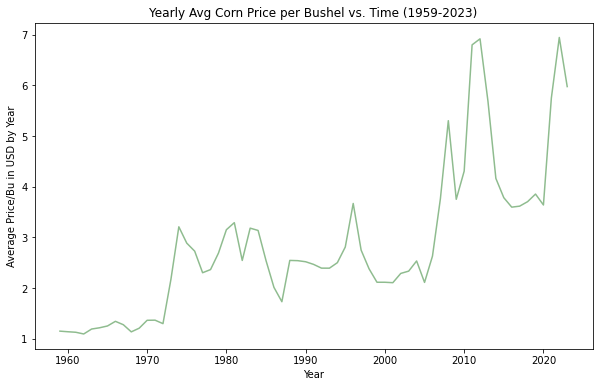

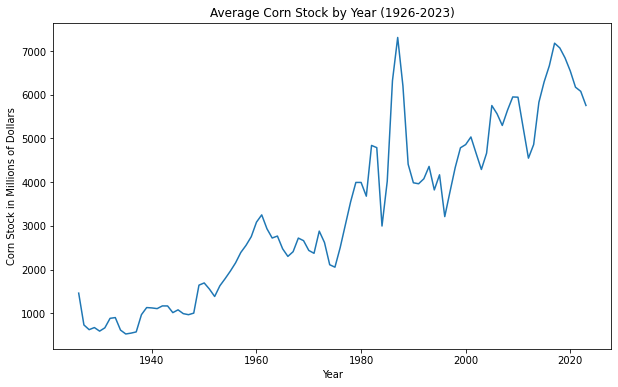

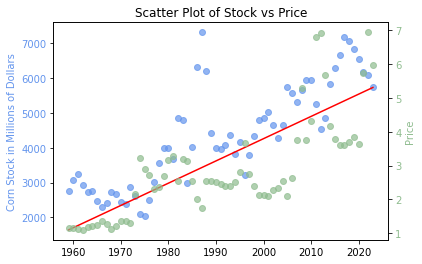

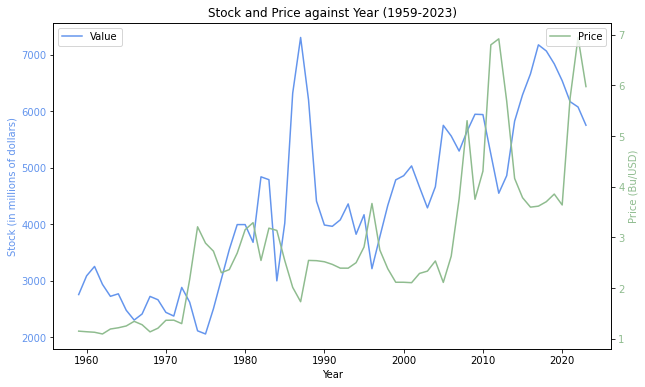

In [44]:
#Creating Price Plot 
#Reading CSV and examining columns
pricedata = pd.read_csv('Pricedata.csv')
#pricedata.head
#pricedata.columns

#Chaging date to date time object and creating a new column with just year
pricedata['Date'] = pd.to_datetime(pricedata['Date'].str.extract(r'(\d{4}-\d{2}-\d{2})')[0])
#https://pandas.pydata.org/docs/reference/api/pandas.Series.str.extract.html
pricedata['Year'] = pricedata['Date'].dt.year

#Creating new data frame with just year and average yearly price 
priceavg = pricedata.groupby('Year')['Price'].mean().reset_index()

#Price Vs Year Plot
plt.figure(figsize=(10, 6))
plt.plot(priceavg['Year'], priceavg['Price'], linestyle='-', color='darkseagreen')
plt.title('Yearly Avg Corn Price per Bushel vs. Time (1959-2023)')
plt.xlabel('Year')
plt.ylabel('Average Price/Bu in USD by Year')
plt.show()

#Creating Stock plot
#Reading CSV and examining columns
stockdata = pd.read_csv('Stockdata.csv')
#stockdata.head
#stockdata.columns

#creating a datetime object
stockdata = stockdata[['Year', 'Value']]
stockdata['day'] = 1
stockdata['month'] = 1
stockdata['Year'] = pd.to_datetime(stockdata[['Year','month','day']])
stockdata['Year'] = stockdata['Year'].dt.year
#stockdata

#Making a new dataframe with average yealy stock and year. 
stockavg = stockdata.groupby('Year')['Value'].mean().reset_index()
#stockavg

plt.figure(figsize=(10, 6))
plt.plot(stockavg['Year'], stockavg['Value'], linestyle='-')
plt.title('Average Corn Stock by Year (1926-2023)')
plt.xlabel('Year')
plt.ylabel('Corn Stock in Millions of Dollars')
plt.show()

#Scatter plot
#Changing the range of the stock data to match the price data
daterange = stockavg[(stockavg['Year'] >= 1959) & (stockavg['Year'] <= 2023)]
stockrange = daterange[['Year', 'Value']]
#Merging Stock and Price data on Year
stockxprice = pd.merge(stockrange, priceavg, on='Year')
stockxprice



#best fit
# Define x and y
x = stockxprice['Year'].values  # This represents the years
y1 = stockxprice['Value'].values  # This represents the stock values
y2 = stockxprice['Price'].values * max(y1) / max(stockxprice['Price'].values)  # This represents the scaled prices

# Combine y1 and y2 to get the combined y values
y = np.concatenate((y1, y2))

# Double the x values to match the length of all y values 
x_combined = np.concatenate((x, x))

# equation of the best fit line
m, b = np.polyfit(x_combined, y, 1)

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()

# Creating a second y-axis for Stock data
ax1.scatter(stockxprice['Year'], stockxprice['Value'], color='cornflowerblue', label='Stock',  alpha=0.7)
ax1.set_ylabel('Corn Stock in Millions of Dollars', color='cornflowerblue')
ax1.tick_params(axis='y', labelcolor='cornflowerblue')

# Plotting Price on the  y-axis
ax2.scatter(stockxprice['Year'], stockxprice['Price'], color='darkseagreen', label='Price',  alpha=0.7)
ax2.set_xlabel('Year')
ax2.set_ylabel('Price', color='darkseagreen')
ax2.tick_params(axis='y', labelcolor='darkseagreen')


ax1.plot(x, m*x + b, color='red', label=f'Best Fit Line: y={m:.2f}x+{b:.2f}')

                
plt.title('Scatter Plot of Stock vs Price')
plt.show()

#Line graph
fig, ax1 = plt.subplots(figsize=(10,6))  # Added figsize for better visibility

# Plotting 'Value' against 'Year' on the primary Y axis
ax1.plot(stockxprice['Year'], stockxprice['Value'], color='cornflowerblue', label='Value')
ax1.set_xlabel('Year')
ax1.set_ylabel('Stock (in millions of dollars)', color='cornflowerblue')
ax1.tick_params(axis='y', labelcolor='cornflowerblue')
ax1.legend(loc='upper left')  # Legend for the primary Y axis

# Creating a second Y axis for 'Price'
ax2 = ax1.twinx()
ax2.plot(stockxprice['Year'], stockxprice['Price'], color='darkseagreen', label='Price')
ax2.set_ylabel('Price (Bu/USD)', color='darkseagreen')
ax2.tick_params(axis='y', labelcolor='darkseagreen')
ax2.legend(loc='upper right')  # Legend for the secondary Y axis
plt.title("Stock and Price against Year (1959-2023)")

plt.show()

# Analyzing Price and Corn Stock
To answer the first part of this guiding question I created graphs of price and stock and compared the two. In these plots we have the yearly average price of corn over 1959 to 2023 from data from macrotrend.net in green. And the stock graph here in blue was made with data from the USDA and has with Corn Stock averaged by year from 1926 to 2023.  Both graphs show an upwards trend over the years. To get a better understanding of this relationship we made a scatter plot from 1959 to 2023 of stock and price vs year/ By analyzing the scatter plot we see both variables are moving close together in an upwards trend. This suggests some patterned behaviour, potentially indicating a relationship between price and stock. However, at first this goes against our initial hypothesis that price and stock are inversely related. But if we look closely at the comprehensive line graph, we can see in cases spikes in one variable, the reverse is happening in the other. Suggesting that an inverse relation may be true. Although both corn stock and price move in a positive linear fashion overall, they are still move inversely. From this influence we can conclude that price and stock do have an inverse relationship 


# Background on Corn Utilization 

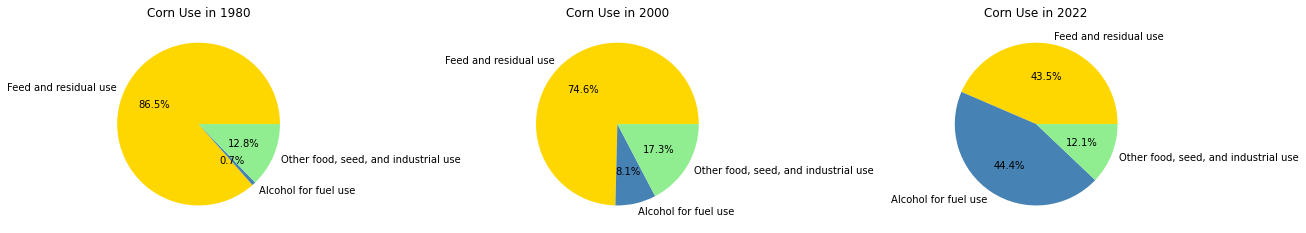

In [49]:
cornuse= pd.read_csv('Cornusedata.csv')
cornuse['day'] = 1
cornuse['month'] = 1
cornuse['Year'] = pd.to_datetime(cornuse[['Year','month','day']])
cornuse['Year'] = cornuse['Year'].dt.year
#cornuse

def pieplot(year, ax):
    df_year = cornuse[cornuse['Year'] == year].copy()
    total = df_year['Billion bushels'].sum()
    df_year['Percentage'] = (df_year['Billion bushels'] / total) * 100
    
    ax.pie(df_year['Percentage'], labels=df_year['Attribute'], colors=['gold', 'steelblue', 'lightgreen'], autopct='%1.1f%%')
    ax.set_title(f'Corn Use in {year}')

# Create a 1x3 grid of plots
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Plot pie charts in each grid space
pieplot(1980, axs[0])
pieplot(2000, axs[1])
pieplot(2022, axs[2])

plt.tight_layout()
plt.show()



# Corn Use: 
To get a deeper understanding of the movement in price we looked at a major use of corn, biofuels. Corn was mostly used for feed but in the 70s there became a push for cheaper fuel. Using ethanol made from corn became a cheap and efficient solution. In 2005 Renewable Fuel Standards became laws and in2007 then president bush signed a policy to increase renewable fuel usage (Gustafson, n.d.). These government policies boosted demand for ethanol in the US and therefore demand for corn. Simultaneously across the globe, many other countries were making the same shift towards ethanol as a renewable fuel option.  As we can see from 1980 to 2000 to 2022, the primary application for corn has shifted. From mostly being used for feed to now, the amount of corn used for feed is equal to corn used for ethanol production in the US.  This exemplifies the importance of looking at increase in biofuel demand and its relationship to the price of corn. 


# Analyzing Price and Demand in Biofuels  

Here is the code for biofuels export line graph, price and biofuels scatterplot and price and biofuels line graph

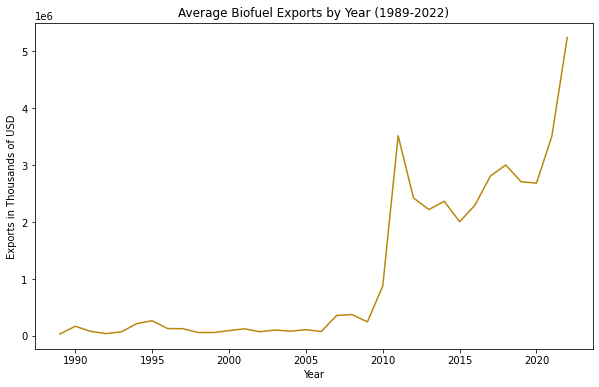

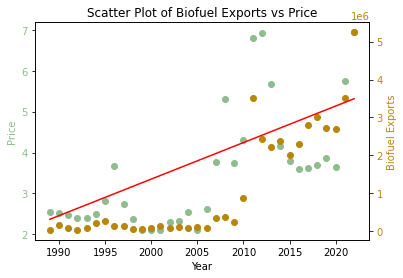

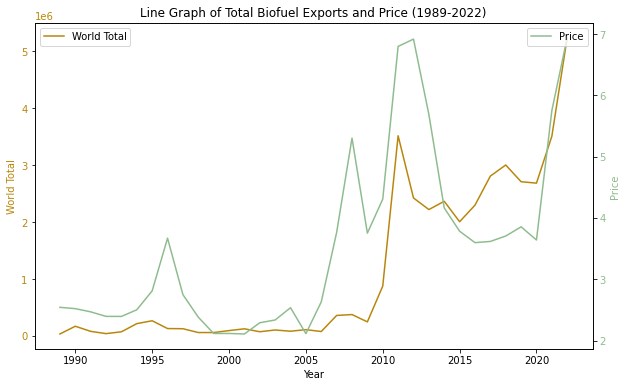

In [46]:
#Biofuels line graph
biodata = pd.read_csv('Biodata2.csv')
biodata = biodata[['Year', 'World Total']]
#biodata
plt.figure(figsize=(10, 6))
plt.plot(biodata['Year'], biodata['World Total'], linestyle='-', color = 'darkgoldenrod')
plt.title('Average Biofuel Exports by Year (1989-2022)')
plt.xlabel('Year')
plt.ylabel('Exports in Thousands of USD')

#Scatter plot
daterange2 = priceavg[(priceavg['Year'] >= 1989) & (priceavg['Year'] <= 2022)]
pricerange = daterange2[['Year', 'Price']]
pricexbio = pd.merge(pricerange, biodata , on='Year')
#pricexbio

fig, ax1 = plt.subplots()
#Best fit line 
x =  pricexbio['Year'].values  # This represents the years
y1 =  pricexbio['World Total'].values  # This represents the stock values
y2 =  pricexbio['Price'].values * max(y1) / max(pricexbio['Price'].values)  # scalling the data point
y = np.concatenate((y1, y2))
x_combined = np.concatenate((x, x))
m, b = np.polyfit(x_combined, y, 1)
# Plotting Price
ax1.scatter(pricexbio['Year'], pricexbio['Price'], color='darkseagreen', label='Price')
ax1.set_xlabel('Year')
ax1.set_ylabel('Price', color='darkseagreen')
ax1.tick_params(axis='y', labelcolor='darkseagreen')
# Creating a second y-axis for World Total
ax2 = ax1.twinx()
ax2.scatter(pricexbio['Year'], pricexbio['World Total'], color='darkgoldenrod', label='Biofuel Exports')
ax2.set_ylabel('Biofuel Exports', color='darkgoldenrod')
ax2.tick_params(axis='y', labelcolor='darkgoldenrod')
#plotting best fit line
plt.plot(x, m*x+b, color = "red")
plt.title('Scatter Plot of Biofuel Exports vs Price')
plt.show()

#line graph
fig, ax1 = plt.subplots(figsize=(10,6)) 

# Plotting 'World Total' against 'Year' on the primary Y axis
ax1.plot(pricexbio['Year'], pricexbio['World Total'], color='darkgoldenrod', label='World Total')
ax1.set_xlabel('Year')
ax1.set_ylabel('World Total', color='darkgoldenrod')
ax1.tick_params(axis='y', labelcolor='darkgoldenrod')
ax1.legend(loc='upper left')

# Creating a second Y axis for 'Price'
ax2 = ax1.twinx()
ax2.plot(pricexbio['Year'], pricexbio['Price'], color='darkseagreen', label='Price')
ax2.set_ylabel('Price', color='darkseagreen')
ax2.tick_params(axis='y', labelcolor='darkseagreen')
ax2.legend(loc= 'upper right')

# Title for the plot
plt.title("Line Graph of Total Biofuel Exports and Price (1989-2022)")

# Display the plot
plt.show()

Now to tackle the second part of my guiding question I created graphs of price and biofuel exports and compared the two. We are using biofuel exports as a measure of demand. In these plots we have the same price data as before in green and the biofuels export graph here in yellow was made with data from the USDA with total biofuel exports in thousands of USD.  Both graphs show an upwards trend over the years. To get a better understanding of this relationship we made a scatter plot from 1959 to 2023 of stock and price vs year. By analyzing the scatter plot we see both variables are clustered together however not moving linearly. Both variables are quite low then seem to jump up after the 2010s. This suggests some patterned behaviour, but from this piece of evidence we can not state a linear relationship. Moving to comprehensive line graph we can see some distinct spikes. Firstly from 2005 to about 2008 we see a spike in price, however there is no dramatic positive or negative change in biofuels exports. This could be due to the policies introduced in 2005 causing corn to become a more valuable commodity. This may have increased the price in the US but not yet be reflected in exports. From 2010 to 2011 there is a dramatic spike in both price and biofuels export. Though policy changes happened in the mid 2000s in can take time for those policies to have an impact which is possibly why there was a delayed reaction for increase in exports. To conclude, these are mainly theories on what is happening in these graphs. Based on the weak scatterplot and the general trend upwards we can not state for certain that that there is a relationship 

Question 3 Summary 

In all, although we see these relationships there are many other factors that affect price including inflation, government policy changes and demand for corn in its other uses such as for feed. To get a more complete understanding of movement in price we would need to look at all these factors.

# Guiding Question Four
## How Does Yield and Price interact?

## Load in dataframes

We loaded in 3 .csv files.  The first was a dataset from the USDA which we renamed to 3i_yeild_pp.csv.  This data set contains data about the yield per acre and the plant population per acre.  It was downloaded from the USDA QuickStats portal which allows you to select paired datasets and output them together with max rows of 50000 rows per download.  we only downloaded data for Illinois, Indiana and Iowa as these were the three states of interest for my analysis.  

The next dataset contains monthly corn futures data and was downloaded from investing.com.  The units are in cents per bushel.  A brief explination of futures contracts and their specific application to corn and corn farming is below.

The next dataset is a dataset which was downloaded from the USDA Quickstats portal.  It contains all chemicals applied to corn including: Nitrogen, Phosphate, Potash, Herbicide, Fungicide and Insecticide.

In [47]:
# Load the CSV files into DataFrames

yeild_pp_df = pd.read_csv('3i_yield_pp.csv')
corn_futures_df = pd.read_csv('corn_futures.csv')
chem_df = pd.read_csv('3I_chemicals.csv')

FileNotFoundError: [Errno 2] No such file or directory: '3i_yield_pp.csv'

## Clean and Structure Raw Chemical Data into Data Frame

To clean and wrangle our Chemical dataset, we first created a date column which held a datetime object. In order to pair this data frame with other dataframes we needed to be able to pair the data by division: 11 = Illinois, 12 = Indiana, 13 = Iowa.  These divisions were stored in the DIVISION column which is named accordingly throuout this project. we then filtered the rows related to fungicides, herbicides, and insecticides and converted all values in the Value column to numeric, grouped by Year and State and then summed the value.  In order to merge the domain and domain category column we had to split the fertilizer data and the pesticide data and bring the relevant data into the Domain column and merge the two.  This cleaned and wrangled data set allowed for ease of pairing any chemical application data which is a yearly metric to whatever monthly data we wanted to investigate.

In [ ]:
# Convert to datetime object
chem_df['Date'] = pd.to_datetime(chem_df['Year'].astype(str) + '-01-01')
chem_df['Year'] = pd.to_numeric(chem_df['Year'])
chem_df['Value'] = pd.to_numeric(chem_df['Value'])

# Create a mapping dictionary for divisions
division_mapping = {'ILLINOIS': 11, 'INDIANA': 12, 'IOWA': 13}

# Create the division column
chem_df['DIVISION'] = chem_df['State'].map(division_mapping)

# Filter rows related to fungicides, herbicides, and insecticides
pesticide_df = chem_df[chem_df['Domain'].str.contains('FUNGICIDE|HERBICIDE|INSECTICIDE')]

# Convert Value column to numeric
pesticide_df['Value'] = pd.to_numeric(pesticide_df['Value'])

# Group by Year and State, and then sum the Value
pesticide_df = pesticide_df.groupby(['Year', 'State','Domain','DIVISION','Date'])['Value'].sum().reset_index()

# Filter rows related to fertilizers
fertilizer_df = chem_df[chem_df['Domain'].str.contains('FERTILIZER')]

# Group by Year and State, and then sum the Value
fertilizer_df = fertilizer_df.groupby(['Year', 'State','Domain Category','DIVISION','Date'])['Value'].sum().reset_index()
fertilizer_df.rename(columns={'Domain Category': 'Domain'}, inplace=True)

# Concatenate with pesticide_df
chem_df = pd.concat([pesticide_df, fertilizer_df], ignore_index=True)
chem_df.sort_values(by='Year', inplace=True)
chem_df.rename(columns={'Year': 'YEAR'}, inplace=True)

chem_df.head(331)


## Chemical Data Frames sorted and grouped for pairing

For ease of analysis later on and flexability to pursue ideas on a whim, we filtered out all the chemicals into their own data frames which came in handy later on in the project.  Most of them were not used but were nice to have on hand.

In [ ]:
# Aggregate nitrogen by year and division
n_year_division = chem_df[(chem_df['DIVISION'].isin([11, 12, 13])) & 
                                   (chem_df['Domain'].str.contains('NITROGEN'))].groupby(['YEAR', 'DIVISION','Domain'])['Value'].sum().reset_index()

# Aggregate potash by year and division
pot_year_division = chem_df[(chem_df['DIVISION'].isin([11, 12, 13])) & 
                                   (chem_df['Domain'].str.contains('POTASH'))].groupby(['YEAR', 'DIVISION','Domain'])['Value'].sum().reset_index()

# Aggregate phosphate by year and division
phos_year_division = chem_df[(chem_df['DIVISION'].isin([11, 12, 13])) & 
                                   (chem_df['Domain'].str.contains('PHOSPHATE'))].groupby(['YEAR', 'DIVISION','Domain'])['Value'].sum().reset_index()

# Aggregate herbicide by year and division
herb_year_division = chem_df[(chem_df['DIVISION'].isin([11, 12, 13])) & 
                                   (chem_df['Domain'].str.contains('HERBICIDE'))].groupby(['YEAR', 'DIVISION','Domain'])['Value'].sum().reset_index()

# Aggregate insecticide by year and division
insect_year_division = chem_df[(chem_df['DIVISION'].isin([11, 12, 13])) & 
                                   (chem_df['Domain'].str.contains('INSECTICIDE'))].groupby(['YEAR', 'DIVISION','Domain'])['Value'].sum().reset_index()

# Aggregate fungicide by year and division
fung_year_division = chem_df[(chem_df['DIVISION'].isin([11, 12, 13])) & 
                                   (chem_df['Domain'].str.contains('FUNGICIDE'))].groupby(['YEAR', 'DIVISION','Domain'])['Value'].sum().reset_index()

n_year_division.head()

## A Brief Overview of Futures

Futures contracts are finanital instruments that allow for a price for an asset to be locked in now for a future delivery date.  They allow both the buyer and the seller to manage the risk of price fluctuations.  In the context of corn, for the farmer, entering a futures contract offers protection from a decrease in the price of corn over the growing season so a farmer can be sure of the price they will recieve for their product before production begins.  As their selling price has already been set, they now have a benchmark to work back from allowing them to precicely dial in their yeild targets which involves making decisions on the quantity of seed, fertilizer and pesticide to purchase and apply.  

So why would anyone buy a futures contract?  It seems like a bad deal to place the risk of a bad growing season or poor quality product onto the buyer, however contracts are by the 5000 bushels (approx 280000 lbs) of corn so poor conditions would reduce yield and therefore the buyer is still only getting what they paid for.  Futures also allow buyers to manage their risk of the price going up.  Say you're Kellogs who produces 34 million kilograms of corn flakes each year, requiring 2.067 million BU of corn per year. In 2012 the price of corn (in Illinois) increased by 19% from January to July.  For Kellogs that would be an increase of $2.44M not budgeted for.  To manage or hedge risk, locking in the price also suits the buyer making for a win-win situation on both sides of the contract.

## Filtered Futures Dataframe

As with all the data, we created a Date column containing a datetime object, a month column using the strftime function from datetime and a Year column.  I filtered from 1980-2022 as we had good data between those dates.  In order to make the data easy to pair with my yearly data, we pivoted to wide format with monthly values as my column headers and my yearly values as my index.  In order to be able to pair on YEAR, we reset the index.

In [ ]:
corn_futures_df['Date'] = pd.to_datetime(corn_futures_df['Date'])
corn_futures_df['Month'] = corn_futures_df['Date'].dt.strftime('%B').str.upper()
corn_futures_df['YEAR'] = corn_futures_df['Date'].dt.year
futures_df = corn_futures_df[(corn_futures_df['Date'] >= '1980-01-01') & 
                        (corn_futures_df['Date'] <= '2022-12-31')]

futures_df = futures_df.pivot(index='YEAR', columns='Month', values='Price')
futures_df.columns.name = None
futures_df.reset_index(inplace=True)


## Yield and Plant Population Data Filtered

In [ ]:
# Aggregate Yield by year and division
yeild_pp_df['Date'] = pd.to_datetime(yeild_pp_df['YEAR'].astype(str) + '-01-01')

yeild_division = yeild_pp_df[(yeild_pp_df['Date'] >= '1980-01-01') & 
                                (yeild_pp_df['Date'] <= '2023-01-01')]
                               

In [ ]:
month_mapping = {
    'JAN': 'JANUARY',
    'FEB': 'FEBRUARY',
    'MAR': 'MARCH',
    'APR': 'APRIL',
    'MAY': 'MAY',
    'JUN': 'JUNE',
    'JUL': 'JULY',
    'AUG': 'AUGUST',
    'SEP': 'SEPTEMBER',
    'OCT': 'OCTOBER',
    'NOV': 'NOVEMBER',
    'DEC': 'DECEMBER',
    'MARKETING YEAR': 'MARKETING YEAR'
}

In [ ]:
corn_price_df = pd.read_csv('3i_price_recieved.csv')
price_recieved = corn_price_df

# Find columns with repeated data
cols_to_drop = [col for col in price_recieved.columns if price_recieved[col].nunique() == 1]

# Drop columns
price_recieved.drop(cols_to_drop, axis=1, inplace=True)
price_recieved.dropna(axis=1,inplace=True)

# Rename for pairing
price_recieved.rename(columns={'Year': 'YEAR'}, inplace=True)
price_recieved.rename(columns={'State ANSI': 'DIVISION'}, inplace=True)
price_recieved.rename(columns={'Value': 'Price'}, inplace=True)
price_recieved.rename(columns={'Period': 'Month'}, inplace=True)
price_recieved['Month'] = price_recieved['Month'].map(month_mapping)
price_recieved['DIVISION'] = price_recieved['DIVISION'] - 6
price_recieved = price_recieved[(price_recieved['YEAR'] >= 1910) & 
                        (price_recieved['YEAR'] <= 2022)]

# Pivot Data Frame
price_df = price_recieved.pivot(index=['YEAR', 'DIVISION'], columns='Month', values='Price')
price_df.columns.name = None
price_df.reset_index(inplace=True)



## Paired Futures Data Frames

In [ ]:

nf_df = pd.merge(n_year_division, futures_df, on=['YEAR'], how='inner')
nf_df.to_csv('nf_df.csv', index=False)

herbf_df = pd.merge(herb_year_division, futures_df, on=['YEAR'], how='inner')
herbf_df.to_csv('herbf_df.csv', index=False)

yield_future_df = pd.merge(yeild_division, futures_df, on=['YEAR'], how='inner')


## Paired Yield Data Frames

The following dataframes contain data merged with my dataset containing yield and plant population data.  These dataframes allow me to investigate corn futures and yield, price recieved and yield, nitrogen application and yield, nitrogen application per plant and yield per plant.  As a side note, the unit of Bushels is a volumetric and largely antiquated unit falling into the category of furlongs, fortnights and score, it's much easier from a conceptual standpoint to convert bushels into pounds as there are 56 Lbs of corn in a bushel.  This unit conversion can't be applied across all agricultural products as there are 60 Lbs of wheat, 24 Lbs of wax beans and 32 Lbs of Oats per bushel etc. making it a great way to confuse the "city folk".  Returning to the previous point, As the yield per plant is a very small number in bushels and weight is much easer to understand, we multiplied by 56 Lbs.  

In [ ]:
# Nitrogen Per Plant and Yield Data
n_ypp_df = pd.merge(n_year_division, yeild_division, on=['YEAR','DIVISION'],how='inner')
n_ypp_df['PLANT POPULATION'] = pd.to_numeric(n_ypp_df['PLANT POPULATION'])
n_ypp_df['YIELD PER PLANT'] = (56 * (n_ypp_df['YIELD'])) / n_ypp_df['PLANT POPULATION']
n_ypp_df['NITROGEN PER PLANT'] = ((n_ypp_df['Value'])) / n_ypp_df['PLANT POPULATION']
n_ypp_df.head()

In [ ]:
price_yield = pd.merge(price_df,yeild_division, on=['YEAR','DIVISION'],how='right')
price_yield['YIELD PER PLANT'] = (56 * (price_yield['YIELD'])) / price_yield['PLANT POPULATION']
price_yield['5Y AVE YIELD'] = price_yield.groupby('DIVISION')['YIELD'].transform(lambda x: x.rolling(window=5).mean())
price_yield['DEVIATION'] = -(price_yield['YIELD'] - price_yield['5Y AVE YIELD'])
price_yield = price_yield[(price_yield['YEAR'] >= 1980) & 
                        (price_yield['YEAR'] <= 2022)]
price_yield.head(20)
price_yield.to_csv('price_yeild.csv', index=False)

# Functions

In [ ]:
def type1_anova(data,formula):

    unique_divisions = data['DIVISION'].unique()
    all_anova_tables = pd.DataFrame()
    
    for division in unique_divisions:
        division_data = data[data['DIVISION'] == division]
        model = ols(formula, data=division_data).fit()
        anova_table = sm.stats.anova_lm(model, typ=1)  # Type 1 ANOVA
        anova_table['DIVISION'] = division
        all_anova_tables = pd.concat([all_anova_tables, anova_table.reset_index()], ignore_index=True)
        
    cols = ['DIVISION'] + [col for col in all_anova_tables.columns if col != 'DIVISION']
    all_anova_tables = all_anova_tables[cols]
    
    return all_anova_tables

In [ ]:
def check_anova_assumptions(data, dependent_var, group_var):

    dfs = []
    unique_groups = data[group_var].unique()
    samples = []

    for group in unique_groups:
        sample = data[data[group_var] == group][dependent_var]
        stat, p = shapiro(sample)
        samples.append(sample)

        df = pd.DataFrame([{
            'Test': f'Shapiro-Wilk (Group {group})',
            'W-statistic': stat,
            'p-value': p,
            'Assumption': 'Normality'
        }])
        dfs.append(df)
    
    stat, p = levene(*samples)
    
    df = pd.DataFrame([{
        'Test': 'Levene',
        'W-statistic': stat,
        'p-value': p,
        'Assumption': 'Homogeneity of Variances'
    }])
    dfs.append(df)
    
    test_results = pd.concat(dfs, ignore_index=True)
    
    return test_results


# How Do Farmers Make Decisions?

In order to make plans for the growing year, farmers need a benchmark to work back from.  Through reading papers, specifically this paper by Goodwin et al. (2012) enlightened me to how yield interacts with price. While news and social media often focus on extreme weather events being the main driver of yield, this paper illustrates how farmers have control; pressing down or easing up on their "growth gas pedal" being fertilizer application, pesticide use and the quantity of seed to plant.  With this understanding, we turned to my futures data, aiming to pinpoint the month(s) of significant influence on decision-making for farmers. This led me to a One-Way or Type 1 ANOVA (Analysis of Variance). In this analysis, each group corresponds to the monthly futures prices for a particular month across different years.

ANOVA delves into two dimensions of variance: within-group and between-group. The former measures the variability of futures prices within a particular month over several years, while the latter assesses the differences in average futures prices between months. The objective was to test if specific month(s) of futures prices accounted for the variance observed in yield and chemical application, notably nitrogen, indicating **when** yield targets are set. Through performing the ANOVA, we retrieved p-values and F-statistic.  

The P-value gives the probability of observing our data under the premise that the Null hypothesis is true.  With a level of significance set at 0.05, P-values that fall below that give us enough evidence to reject the Null and go with the alternative hypothesis.  The F-statistic helps us understand the varience, giving us a ratio of the variance observed between the groups to the variance with-in groups.  in opposition to the P-Value, A higher F-statistic shows a more pronounced varience between the groups.

$H_0$: There is no significant difference between the means of the groups.
$H_A$: There is a significant difference between the means of the groups.

Before we can apply this test however, we must check assumptions to determine the validity of the ANOVA. The assumptions are as follows:
- Normality: The data should follow a normal distribution
- Independance:
- Homogeneity of Variances:
- Random Sampling: 

To meet these conditions, we wrote a function called check_anova_assumptions which uses modules from the scipy.stats library.  The specific tests we used were the Shapiro-Wilks test for normality and the Levine Test for Homogeneity of Variances.

In [ ]:
check = check_anova_assumptions(yield_future_df, 'YIELD', 'DIVISION')

header_color = 'rgba(0, 255, 200, 0.3)' 
bg_table_color = 'rgba(100, 100, 100, 0.4)'  
bg_color = 'rgba(40, 40, 40, 1)'


fig = go.Figure(data=[go.Table(
    header=dict(
        values=list(check.columns),
        fill_color=header_color,
        align='center',
        font=dict(color='White', size=12)
    ),
    cells=dict(
        values=[check[col] for col in check.columns],
        fill_color=bg_table_color,
        align='center',
        font=dict(color='white', size=12)
    ))
])

fig.update_layout(
    title="ANOVA Assumption Test Results",
    titlefont=dict(color='white', size=20),
    paper_bgcolor=bg_color, 
    margin=dict(l=50, r=50, b=100, t=50)  
)

fig.show()

As assumptions were all met, we proceded with my ANOVA.  

In [ ]:
predictor_columns = ['JANUARY', 'FEBRUARY', 'MARCH', 'APRIL', 'MAY', 'JUNE', 'JULY', 'AUGUST', 'SEPTEMBER', 'OCTOBER', 'NOVEMBER', 'DECEMBER']
formula = "YIELD ~ JANUARY + FEBRUARY + MARCH + APRIL + MAY + JUNE + JULY + AUGUST + SEPTEMBER + OCTOBER + NOVEMBER + DECEMBER"
yieldfutures_p_sig = type1_anova(data = yield_future_df, formula = formula)
yieldfutures_p_sig_piv = yieldfutures_p_sig.pivot(index = 'index', columns='DIVISION', values='PR(>F)').reindex(predictor_columns)
yieldfutures_F_sig_piv = yieldfutures_p_sig.pivot(index = 'index', columns='DIVISION', values='F').reindex(predictor_columns)
yieldfutures_p_sig_piv.head(36)

# Set style
sns.set(style="dark", palette="coolwarm")

# Assuming yieldfutures_p_sig_piv is your data
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Set the background color of the figure
fig.patch.set_facecolor('#2e2e2e')

# Plot the heatmaps with annotations
sns.heatmap(yieldfutures_p_sig_piv, annot=True,  ax=axes[0], cmap='coolwarm_r', annot_kws={"color": 'white'})
axes[0].set_title("P-Value: Futures on Yield", color='white')

sns.heatmap(yieldfutures_F_sig_piv, annot=True, ax=axes[1], cmap='coolwarm', annot_kws={"color": 'white'})
axes[1].set_title("F-Value: Futures on Yield", color='white')

# Set the color of the axes labels and ticks
for ax in axes:
    ax.tick_params(color='white', labelcolor='white')
    for spine in ax.spines.values():
        spine.set_edgecolor('white')

plt.show()

In [ ]:
predictor_columns = ['JANUARY', 'FEBRUARY', 'MARCH', 'APRIL', 'MAY', 'JUNE', 'JULY', 'AUGUST', 'SEPTEMBER', 'OCTOBER', 'NOVEMBER', 'DECEMBER']
formula = "Value ~ JANUARY + FEBRUARY + MARCH + APRIL + MAY + JUNE + JULY + AUGUST + SEPTEMBER + OCTOBER + NOVEMBER + DECEMBER"
Nfutures_p_sig = type1_anova(data = nf_df, formula = formula)
Nfutures_p_sig_piv = Nfutures_p_sig.pivot(index = 'index', columns='DIVISION', values='PR(>F)').reindex(predictor_columns)
Nfutures_F_sig_piv = Nfutures_p_sig.pivot(index = 'index', columns='DIVISION', values='F').reindex(predictor_columns)


# Set style
sns.set(style="dark", palette="coolwarm")


fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Set the background color of the figure
fig.patch.set_facecolor('#2e2e2e')

# Plot the heatmaps with annotations
sns.heatmap(Nfutures_p_sig_piv, annot=True,  ax=axes[0], cmap='coolwarm_r', annot_kws={"color": 'white'})
axes[0].set_title("P-Value: Futures on Nitrogen Application", color='white')

sns.heatmap(Nfutures_F_sig_piv, annot=True, ax=axes[1], cmap='coolwarm', annot_kws={"color": 'white'})
axes[1].set_title("F-Value: Futures on Nitrogen Application", color='white')

# Set the color of the axes labels and ticks
for ax in axes:
    ax.tick_params(color='white', labelcolor='white')
    for spine in ax.spines.values():
        spine.set_edgecolor('white')

plt.show()

## Results of ANOVA

From the one-way ANOVA, we returned a series of P-Values and F-Statistics.  To easily spot the trend in the data, we plotted these values on an annotated heatmap.  This helped us easily see that the January futures price is signigficant to both the yield per acre and the quantity of nitrogen applied per acre.  Also of note, the growing months (May through August) show some significance to the yield as the P-Values are below 0.05.  That being said, the F-statistics over these months is also low, signifying that the variance between the groups is similar to variance within groups.  

Concrete takeaways are that we should focus on the January futures price as the guiding benchmark for farmers to set their yield targets.  

## How Accuratly can Farmer's Hedge their Risk Using the January Futures Price?

As the ANOVA indicated the significance of the January futures price on yield and nitrogen application, we decided to evaluate the **quality** of the benchmark in hedging risk and setting yield targets.  To get a better sense of how Futures prices and the price recieved compare over time, we plotted the two together for January, July and April.  

In [ ]:

sns.set_style("darkgrid")

# Style
plt.rcParams['text.color'] = 'white'
plt.rcParams['axes.labelcolor'] = 'white'
plt.rcParams['xtick.color'] = 'white'
plt.rcParams['ytick.color'] = 'white'
plt.rcParams['axes.edgecolor'] = 'white'
plt.rcParams['grid.color'] = '#444444'
plt.rcParams['axes.facecolor'] = '#2e2e2e'
plt.rcParams['figure.facecolor'] = '#2e2e2e'

# Filter the data for years between 1980 and 2022
price_df_filtered = price_df[(price_df['YEAR'] >= 1980) & (price_df['YEAR'] <= 2022)]
futures_df_filtered = futures_df[(futures_df['YEAR'] >= 1980) & (futures_df['YEAR'] <= 2022)]

# Create the plots with subplots 
fig, axes = plt.subplots(3, 1, figsize=(12, 18))

# List of months to plot
months = ['JANUARY', 'JULY', 'APRIL']

# Iterate through each subplot to plot data for each month
for ax, month in zip(axes, months):
    # price_df on the primary y-axis
    ax.plot(price_df_filtered['YEAR'], price_df_filtered[month], label=f'{month} (Price Recieved)', marker='o', color='tab:blue')
    
    # Secondary y-axis for Futures data
    ax2 = ax.twinx()
    ax2.plot(futures_df_filtered['YEAR'], futures_df_filtered[month], label=f'{month} (Futures Price)', marker='o', linestyle='--', color='tab:green')
    
    # Labels and titles
    ax.set_xlabel('Year')
    ax.set_ylabel(f'Price Received', color='tab:blue')
    ax.tick_params(axis='y', labelcolor='tab:blue')
    ax2.set_ylabel(f'Futures Price', color='tab:green')
    ax2.tick_params(axis='y', labelcolor='tab:green')
    ax.set_title(f'Monthly Prices for {month} from 1980 to 2022')
    
    # Legends
    ax.legend(loc='upper left')
    ax2.legend(loc='upper right')


plt.tight_layout()


plt.show()

As can be seen from looking at these plots, the January Futures price is the closest to the price recieved of the three months.  Purely visually speaking, both the April and July Futures prices tend to under predict the price recieved.  For the futures price to underpredict the price recieved, that poses a risk to farmer's bottom line as they would tend to set low yield targets and would inaccuratly hedge on average losing money compared to the price recieved.  

# Understanding Basis

In response to our video presentation, Claire asked an excellent question regarding how accuratly farmers are able to hedge using the January futures price.  To investivate this, we plotted a probability distrobution of the differene in cents between the January price recieved and the January futures price. This calculation is called the "Basis" and it represents the difference in the local cash price of a commodity and the corresponding futures contract for that commodity. The basis calculation is performed below.

In [ ]:

futures_df = futures_df[['YEAR', 'JANUARY']]
price_df = price_df[['YEAR', 'JANUARY']]

# Merge the two dataframes on the YEAR column
basis_df = pd.merge(futures_df, price_df, on='YEAR', suffixes=('_FUTURES', '_RECEIVED'))

# Convert the received price to cents
basis_df['JANUARY_RECEIVED'] = basis_df['JANUARY_RECEIVED'] * 100  # 1 dollar = 100 cents

# Calculate the difference between the futures price and the received price for January
basis_df['DIFFERENCE'] = basis_df['JANUARY_FUTURES'] - basis_df['JANUARY_RECEIVED']


# Calculate descriptive statistics
mean_difference = np.mean(basis_df['DIFFERENCE'])
std_difference = np.std(basis_df['DIFFERENCE'])

# Your color specifications
bar_color = 'rgba(0, 255, 200, 1)'
bg_table_color = '#64646466'
bg_color = '#2e2e2e'  # converting the rgba color to hexadecimal

# Set the text color
plt.rcParams['text.color'] = 'white'
plt.rcParams['axes.labelcolor'] = 'white'
plt.rcParams['axes.edgecolor'] = 'white'
plt.rcParams['xtick.color'] = 'white'
plt.rcParams['ytick.color'] = 'white'

# Set the aesthetic style of the plots
sns.set_style("darkgrid", {"axes.facecolor": bg_table_color, "grid.color": ".6", "grid.linestyle": ":"})

# Create a histogram of the differences
plt.figure(figsize=(12, 6))
sns.histplot(basis_df['DIFFERENCE'], bins=30, kde=True, color='teal', label='Data')

# Plot a normal distribution fit
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mean_difference, std_difference)
plt.plot(x, p, color = 'teal', linewidth=2, label='Normal Distribution Fit')

# Add titles and labels
plt.title('Probability Distribution of the Difference between January Futures Price and Received Price', color='white')
plt.xlabel('Difference (cents per bushel)', color='white')
plt.ylabel('Frequency', color='white')
plt.legend()

# Set the background color of the figure and axes
plt.gca().set_facecolor(bg_table_color)
plt.gcf().set_facecolor(bg_color)

# Set the tick colors to white
ax = plt.gca()
ax.tick_params(colors='white')
legend = plt.legend(title='Legend', title_fontsize='16', fontsize='12')
plt.setp(legend.get_texts(), color='white')
# Show the plot
plt.show()

### Result of the Basis Probability Distribution

This probability distribution returned very interesing results as it suggests that farmers accuratly hedge using the January futures price, yeilding on average a ~25 cent gain over the price recieved.  This is very significant for farmers as we will explain.  Using the US average yield for 2022 of 173 BU/Acre and a farm size of 1500 Acres, this works out to a difference of $64875.  In addition, the distribution is right skewed demonstrating significant upside and limited downside for farmers.

## Nitrogen Application Trends over Time

In the comments on the video, there were a few questions about fertilizer use and how it compares to yield.  As was described earlier, yield has increased 600% over the last 100 years so a comparison of the fertalizer use would add colour to that trend.  As a bit of background, corn is a very nitrogen hungry crop and thus the fertilizer matrix of nitrogen, phosphate and potash is composed of almost 50% nitrogen.  In addition it is also the most expensive component of the matrix at $0.83 per pound.  

A couple of innovations in process that we identified in our research were: “Corn following corn” vs “Corn following Soybeans” and "Split N".  For the first method, farmers simply rotate their crops between soybeans and corn as soybeans are significantly less nitrogen hungry and allow for the nitrogen levels in the soil to replenish.  This difference is pronounced as 187 units of nitrogen are used vs 134 units for a yield target of 204 and 202 BU respectivly.  At $0.83 per pound and a difference of 53 units per acre, that works out to a savings of $65985 over 1500 acres.  

The second advancement was the "Split N" method of fertilizer application where farmers split their N application into 2 applications rather than one application.  The first application is typically in April which is the pre-planting season.  When farmers use one application, they need to apply a heavier dose than the 2 applications combined.  This also poses a significant risk especially for farmers with well draining soil types as a rain could easily wash that nitrogen out of the soil and into the groundwater. By splitting the nitrogen application, farmers are able to give a fresh does of nitrogen when the plants most need it. The 

In [ ]:
tr_color1 = 'rgba(0, 255, 255, 1)' # Fluorescent Cyan Neon
tr_color2 = 'rgba(255, 255, 0, 1)' # Fluorescent Yellow Neon


# Create subplots with 3 rows and 1 column
fig = make_subplots(rows=3, cols=1, subplot_titles=("Illinois", "Indiana", "Iowa"),
                    specs=[[{"secondary_y": True}], [{"secondary_y": True}], [{"secondary_y": True}]])

divisions = [11, 12, 13]

# Loop through each division
for i, div in enumerate(divisions, start=1):
    # Filter data by division
    filtered_df = n_ypp_df[n_ypp_df['DIVISION'] == div]
    
    # Create neon-like traces for Nitrogen and Yield Per Plant
    trace1 = create_trace(filtered_df['YEAR'], filtered_df['NITROGEN PER PLANT'], 'Nitrogen Applied/Plant (Lbs)', tr_color1)
    trace2 = create_trace(filtered_df['YEAR'], filtered_df['YIELD PER PLANT'], 'Yield Per Plant (Lbs)', tr_color2)

    
    # Add traces to subplot
    fig.add_trace(trace1, row=i, col=1)
    fig.add_trace(trace2, row=i, col=1, secondary_y=True)

# Update layout for a modern look
fig.update_layout(
    margin=dict(l=100, r=100, b=30, t=50),
    height=600, width=900,
    plot_bgcolor='rgba(40, 40, 40, 1)',
    paper_bgcolor='rgba(40, 40, 40, 1)',
    font=dict(color='white', family="Arial, sans-serif"),
    legend=dict(
        x=1,
        y=0.7,
        traceorder="normal",
        orientation="v",
        yanchor="middle"
    )
)
for i in range(1, 4):
    fig.update_xaxes(
        gridcolor='rgba(60, 60, 60, 1)',
        title='Year',
        row=i, col=1
    )
    fig.update_yaxes(
        gridcolor='rgba(0, 255, 255, 0.4)',
        title='Yeild (lbs)',
        row=i, col=1
    )
    fig.update_yaxes(
        gridcolor='rgba(255, 255, 0, 0.4)',
        title='N Applied (lbs)',
        row=i, col=1,
        secondary_y=True
    )
# Show plot
fig.show()

## References
Ag Decision Maker. (2023). Estimated Costs of Crop Production in Iowa–2023. Iowa State University Extension and Outreach. https://www.extension.iastate.edu/agdm/crops/pdf/a1-20.pdf

Bessin, R. (2019, November). BT-Corn: What it is and how it works | Entomology. http://entomology.ca.uky.edu/ef130

Borunda, A. (2022, January 24). U.S. corn production is booming—but not for the reasons scientists hoped. Environment. https://www.nationalgeographic.com/environment/article/us-corn-production-booming-but-its-future-isnt-clear?loggedin=true&rnd=1697610317523

Gramig, B. M., Massey, R., & Do Yun, S. (2017). Nitrogen application decision-making under climate risk in the US Corn Belt. Climate Risk Management, 15, 82-89. https://www.sciencedirect.com/science/article/pii/S221209631630047X 

Gustafson, C. (n.d.). History of Ethanol Production and Policy. History of Ethanol Production and Policy - Energy.https://www.ag.ndsu.edu/energy/biofuels/energy-briefs/history-of-ethanol-production-and-policy#:~:text=Today’s%20ethanol%20industry%20began%20in,ease%20of%20transformation%20into%20alcohol 

Herbicide tolerant crops. (n.d.). Beyond Pesticides. https://www.beyondpesticides.org/resources/genetic-engineering/herbicide-tolerance

Index of divisional, statewide, regional and national drought files. National Centers for Environmental Information. (March, 2014). https://www1.ncdc.noaa.gov/pub/data/cirs/climdiv/drought-readme.txt 

Licht, M. (2021, April 9). Considerations for corn seeding rates | Integrated Crop Management. https://crops.extension.iastate.edu/blog/mark-licht-zachary-clemens/considerations-corn-seeding-rates

Niederhuber, M. (2015, August 11). Insecticidal Plants: The tech and safety of GM BT crops - Science in the News. Science in the News. https://sitn.hms.harvard.edu/flash/2015/insecticidal-plants/

USDA ERS - Recent trends in GE adoption. (n.d.). https://www.ers.usda.gov/data-products/adoption-of-genetically-engineered-crops-in-the-u-s/recent-trends-in-ge-adoption/

Wilkerson, J. (2017, October 1). Why Roundup Ready Crops Have Lost their Allure - Science in the News. https://sitn.hms.harvard.edu/flash/2015/roundup-ready-crops/
